# Object Visual Search Analysis

In [1]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats 


### Exclusion Criteria

Pre-registered: https://osf.io/qfb3u
    

In [2]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [4]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [5]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  274


In [7]:
num_trials = 24

In [8]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    prac_too_many_dist = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            prac_too_many_dist.append(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2, prac_too_many_dist
    

In [9]:
pracTries_cleaned_data, prac_dist = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 9


In [12]:
len(pracTries_cleaned_data.subjID.unique())

265

In [13]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
            
#         else:
#             print(subj_acc)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [14]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  27
Number of participants that did not respond for 4 or more trials: 4
Number of participants left:  238


In [16]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [17]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 5000], num_trials)


238
238


In [22]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [23]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 22)

Number of Participants with >= 10% trials removed:  46
Number of participants left:  192


In [24]:
raw_final_data = finalTrialCount_data.copy(deep=True)
len(raw_final_data.subjID.unique())

192

In [25]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score RT
        average_RT = subj_df["RT"].mean()
        std_RT = subj_df["RT"].std()
        subj_RTs = np.array(list(subj_df["RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.insert(4, 'Z-Scored RT',zscored_subj_RTs)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2

In [26]:
zs_final_data = zscored_outcomes(raw_final_data)

In [27]:
def recode_ratings(df):
    '''
    4, 3+5, 2+6, 1+7
    labeled: 4, 3, 2, 1
    where 4 is scaled, and 1 is most mis-scaled
    '''
    
    df['rating'] = df['rating'].replace(5, 3)
    df['rating'] = df['rating'].replace(6, 2)
    df['rating'] = df['rating'].replace(7, 1) 

    return df

In [28]:
recoded_ratings_data = recode_ratings(zs_final_data)

In [31]:
def add_image_col(df):
    """
    """
    image_col = []
    
    for idx, row in df.iterrows():
        image_col.append(row['image'][:-6])

    
    return np.array(image_col)

In [32]:
image_column = add_image_col(recoded_ratings_data)

# # add misscaled column to dataframe 
recoded_ratings_data.insert(14, "image_name", image_column)


In [138]:
final_data = recoded_ratings_data.copy(deep=True)

In [65]:
def add_cannonicalSize_col(df):
    """
    """
    big_objects = ['clipboard', 'kettle', 'laptop', 'notebook', 'pot', 'toaster']
    small_objects = ['binderclip', 'eraser', 'flashdrive', 'saltshaker', 'sponge', 'spoon']
    
    cannonicalSize_col = []
    
    for idx, row in df.iterrows():
        obj = row['object']
        if obj in big_objects:
            cannonicalSize_col.append('large')
        if obj in small_objects:
            cannonicalSize_col.append('small') 
    
    return np.array(cannonicalSize_col)

In [66]:
cannonicalSize_column = add_cannonicalSize_col(final_data)


In [67]:

# add cannonical size column to dataframe 
final_data.insert(14, "cannonical_size", cannonicalSize_column)

In [68]:
final_data.to_csv('visualSearch_data.csv', index=False)

In [35]:
len(final_data.subjID.unique())

192

### Read in data if outlier exclusion has already been run

In [2]:
final_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/OSS/visualSearch_data.csv')

In [3]:
fig_destination = '/Users/prachimahableshwarkar/Documents/GW/OSS/figures'

## Accuracy

In [4]:
np.sum(np.array(final_data['accuracy']))/len(np.array(final_data['accuracy']))


0.9700374531835206

In [5]:
np.std(np.array(final_data['accuracy']))/np.sqrt(len(np.array(final_data['accuracy'])))

0.0025304835755174926

In [6]:
# data split by object-scene size congruency aka scene zoom 

zo_df = final_data.loc[final_data['presentationSize']=='large']
zi_df = final_data.loc[final_data['presentationSize']=='small']

zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))

zo_acc_sem = np.std(np.array(zo_df['accuracy']))/np.sqrt(len(np.array(zo_df['accuracy'])))
zi_acc_sem = np.std(np.array(zi_df['accuracy']))/np.sqrt(len(np.array(zi_df['accuracy'])))


zo_acc, zi_acc

(0.9741568112133158, 0.9658687943262412)

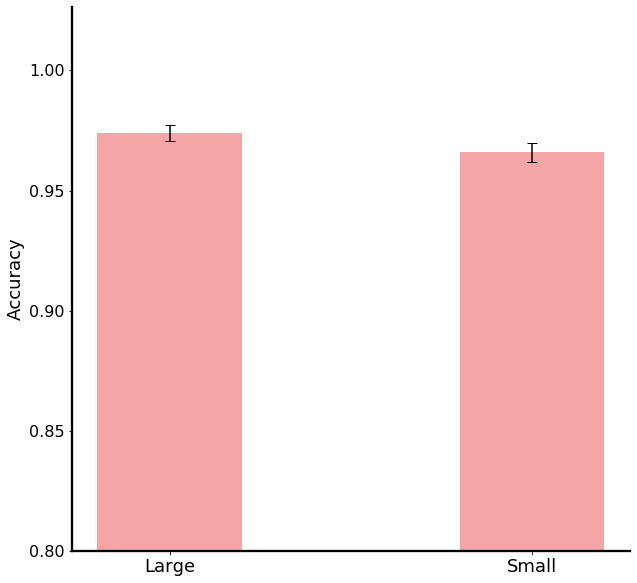

In [7]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Large':zo_acc, 'Small':zi_acc}

courses = list(data.keys())
values = list(data.values())


plt.bar(courses, values, color ='lightcoral', alpha=0.7,
        width = 0.4, yerr=[zo_acc_sem, zi_acc_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.yticks(fontsize=16) 
plt.ylabel("Accuracy", fontsize=18)
plt.ylim(0.8)
# plt.title('E5V2 Presentation Size RT', fontsize=20)
plt.show()

In [8]:
misscaled_zo = zo_df.loc[zo_df['scale'] =='misscaled'] 
misscaled_zi = zi_df.loc[zi_df['scale'] =='misscaled']
# misscaled = misscaled_zo.append(misscaled_zi)

misscaled = final_data.loc[final_data['scale']=='misscaled']

scaled_zo = zo_df.loc[zo_df['scale'] =='scaled'] 
scaled_zi = zi_df.loc[zi_df['scale'] =='scaled']
# scaled = scaled_zo.append(scaled_zi)

scaled = final_data.loc[final_data['scale']=='scaled']

misscaled_acc = np.sum(np.array(misscaled['accuracy']))/len(np.array(misscaled['accuracy']))
scaled_acc = np.sum(np.array(scaled['accuracy']))/len(np.array(scaled['accuracy']))

misscaled_acc_sem = np.std(np.array(misscaled['accuracy']))/np.sqrt(len(np.array(misscaled['accuracy'])))
scaled_acc_sem = np.std(np.array(scaled['accuracy']))/np.sqrt(len(np.array(scaled['accuracy'])))


misscaled_acc, scaled_acc

(0.9635164835164836, 0.9765901060070671)

In [15]:
import scipy.stats as stats

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(np.array(misscaled['accuracy']), np.array(scaled['accuracy']))

print(f"F-Value: {f_value}, P-Value: {p_value}")

F-Value: 6.679898107856337, P-Value: 0.009781566435792657


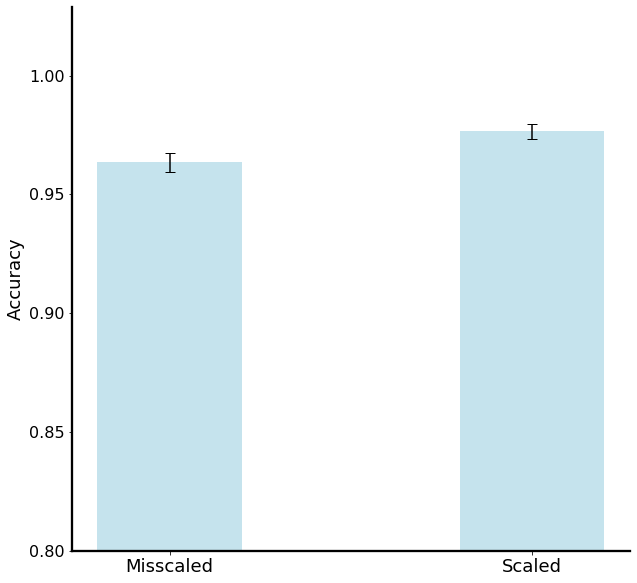

In [9]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Misscaled':misscaled_acc, 'Scaled':scaled_acc}

courses = list(data.keys())
values = list(data.values())
   
# creating the bar plot
plt.bar(courses, values, color ='lightblue', alpha=0.7,
        width = 0.4, yerr=[misscaled_acc_sem, scaled_acc_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.yticks(fontsize=16) 
plt.ylim(0.8)
plt.ylabel("Accuracy", fontsize=18)
plt.show()

In [10]:
zi_scaled = final_data[(final_data['presentationSize'] == 'small') & (final_data['scale'] == 'scaled')]
zo_scaled = final_data[(final_data['presentationSize'] == 'large') & (final_data['scale'] == 'scaled')]

zi_misscaled = final_data[(final_data['presentationSize'] == 'large') & (final_data['scale'] == 'misscaled')]
zo_misscaled = final_data[(final_data['presentationSize'] == 'small') & (final_data['scale'] == 'misscaled')]


zi_scaled_acc = np.sum(np.array(zi_scaled['accuracy']))/len(np.array(zi_scaled['accuracy']))
zi_scaled_acc_sem = np.std(np.array(zi_scaled['accuracy']))/np.sqrt(len(np.array(zi_scaled['accuracy'])))

zo_scaled_acc = np.sum(np.array(zo_scaled['accuracy']))/len(np.array(zo_scaled['accuracy']))
zo_scaled_acc_sem = np.std(np.array(zo_scaled['accuracy']))/np.sqrt(len(np.array(zo_scaled['accuracy'])))

zi_misscaled_acc = np.sum(np.array(zi_misscaled['accuracy']))/len(np.array(zi_misscaled['accuracy']))
zi_misscaled_acc_sem = np.std(np.array(zi_misscaled['accuracy']))/np.sqrt(len(np.array(zi_misscaled['accuracy'])))

zo_misscaled_acc = np.sum(np.array(zo_misscaled['accuracy']))/len(np.array(zo_misscaled['accuracy']))
zo_misscaled_acc_sem = np.std(np.array(zo_misscaled['accuracy']))/np.sqrt(len(np.array(zo_misscaled['accuracy'])))

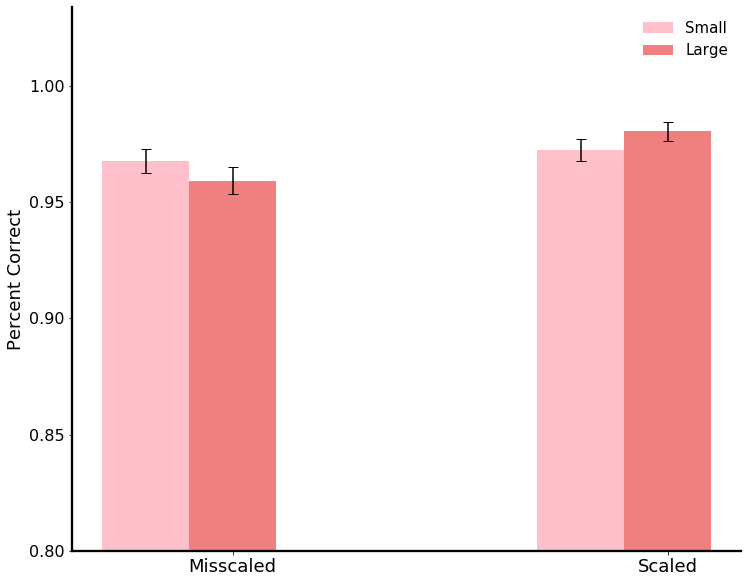

In [11]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

#                   Misscaled               Scaled
Acc_pSmall =   [zi_misscaled_acc, zi_scaled_acc]
yerr_pSmall =  [zi_misscaled_acc_sem, zi_scaled_acc_sem]


Acc_pLarge =   [zo_misscaled_acc, zo_scaled_acc]
yerr_pLarge =  [zo_misscaled_acc_sem, zo_scaled_acc_sem]


width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_pSmall, width, color='pink', label='Small', yerr=yerr_pSmall, capsize=5)
plt.bar(x, Acc_pLarge, width, color='lightcoral', label='Large', yerr=yerr_pLarge, capsize=5)


plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.ylim(0.80)
plt.yticks(fontsize=16) 
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15, frameon=False)
# plt.title('E5V2-Accuracy', fontsize=22)
plt.show()

In [41]:
cong_scaled = final_data[(final_data['objSceneSemCong'] == 1) & (final_data['scale'] == 'scaled')]
incong_scaled = final_data[(final_data['objSceneSemCong'] == 0) & (final_data['scale'] == 'scaled')]

cong_misscaled = final_data[(final_data['objSceneSemCong'] == 1) & (final_data['scale'] == 'misscaled')]
incong_misscaled = final_data[(final_data['objSceneSemCong'] == 0) & (final_data['scale'] == 'misscaled')]


cong_scaled_acc = np.sum(np.array(cong_scaled['accuracy']))/len(np.array(cong_scaled['accuracy']))
cong_scaled_acc_sem = np.std(np.array(cong_scaled['accuracy']))/np.sqrt(len(np.array(cong_scaled['accuracy'])))

incong_scaled_acc = np.sum(np.array(incong_scaled['accuracy']))/len(np.array(incong_scaled['accuracy']))
incong_scaled_acc_sem = np.std(np.array(incong_scaled['accuracy']))/np.sqrt(len(np.array(incong_scaled['accuracy'])))

cong_misscaled_acc = np.sum(np.array(cong_misscaled['accuracy']))/len(np.array(cong_misscaled['accuracy']))
cong_misscaled_acc_sem = np.std(np.array(cong_misscaled['accuracy']))/np.sqrt(len(np.array(cong_misscaled['accuracy'])))

incong_misscaled_acc = np.sum(np.array(incong_misscaled['accuracy']))/len(np.array(incong_misscaled['accuracy']))
incong_misscaled_acc_sem = np.std(np.array(incong_misscaled['accuracy']))/np.sqrt(len(np.array(incong_misscaled['accuracy'])))



In [47]:
# cong_scaled['accuracy'].to_list()

In [48]:
acc_data = {'cong_scaled': cong_scaled['accuracy'].to_list(),
      'incong_scaled': incong_scaled['accuracy'][:-8].to_list(),
      'cong_misscaled': cong_misscaled['accuracy'][:-4].to_list(),
      'incong_misscaled': incong_misscaled['accuracy'][:-15].to_list()}

acc_df = pd.DataFrame(acc_data)

for key in acc_data:
    print(len(acc_data[key]))

1128
1128
1128
1128


In [49]:
acc_df

,cong_scaled,incong_scaled,cong_misscaled,incong_misscaled
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
1123,1,1,1,1
1124,1,1,1,1
1125,1,1,1,1
1126,1,1,1,1


In [50]:
acc_df.to_csv('congruence_scale_accuracy.csv', index=False)

In [13]:
import random
from scipy.stats import ttest_rel

def run_ttest(list0, list1):
    if len(list0) != len(list1):
        size = min(len(list0), len(list1))
        # print(size)
        # print(len(list0), len(list1))
        sampled_list0 = random.sample(list0, size)
        sampled_list1 = random.sample(list1, size)
    else:
        sampled_list0 = list0
        sampled_list1 = list1

    t_statistic, p_value = ttest_rel(sampled_list0, sampled_list1)

    return t_statistic, p_value


def main_ttest(reps, list0, list1):
    t_vals = []
    p_vals = []
    for i in range(reps):
        tv, pv = run_ttest(list0, list1)
        t_vals.append(tv)
        p_vals.append(pv)

    return np.mean(np.array(t_vals)), np.mean(np.array(p_vals))

In [85]:
print('Scaled: Cong vs Incong')
main_ttest(10000, cong_scaled['accuracy'].to_list(), incong_scaled['accuracy'].to_list())

Scaled: Cong vs Incong


(-1.8305878458689475, 0.06797909087039682)

In [86]:
print('Misscaled: Cong vs Incong')
main_ttest(10000, cong_misscaled['accuracy'].to_list(), incong_misscaled['accuracy'].to_list())

Misscaled: Cong vs Incong


(-2.1661168114484264, 0.030962668805382492)

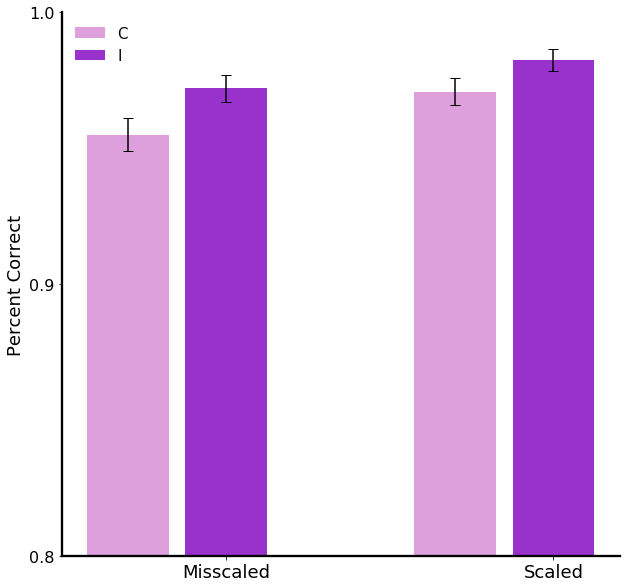

In [14]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

#                   Misscaled               Scaled
Acc_objSemCong =   [cong_misscaled_acc, cong_scaled_acc]
yerr_objSemCong =  [cong_misscaled_acc_sem, cong_scaled_acc_sem]


Acc_objSemIncong =   [incong_misscaled_acc, incong_scaled_acc]
yerr_objSemIncong =  [incong_misscaled_acc_sem, incong_scaled_acc_sem]


width = 0.25
  
# plot data in grouped manner of bar type
plt.bar(x-0.3, Acc_objSemCong, width, color='plum', label='C', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkorchid', label='I', yerr=yerr_objSemIncong, capsize=5)


plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.ylim(0.80, 1)
plt.yticks(np.arange(0.8, 1.01, .1), fontsize=16)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=0, fontsize=15, frameon=False)
# plt.title('E5V2-Accuracy', fontsize=22)

plt.savefig(fig_destination + '/EXP1-ACC.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()



In [90]:
# object scene semantic congruency 
# var = objectScene1SemanticCongruency
# acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))

misscaled_zo_objSemCong = misscaled_zo.loc[misscaled_zo["objSceneSemCong"]==1]
misscaled_zo_objSemIncong = misscaled_zo.loc[misscaled_zo["objSceneSemCong"]==0]

misscaled_zo_objSemCong_acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))
misscaled_zo_objSemIncong_acc =np.sum(np.array(misscaled_zo_objSemIncong['accuracy']))/len(np.array(misscaled_zo_objSemIncong['accuracy']))

misscaled_zo_objSemCong_sem = np.std(np.array(misscaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemCong['accuracy'])))
misscaled_zo_objSemIncong_sem = np.std(np.array(misscaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemIncong['accuracy'])))


misscaled_zi_objSemCong = misscaled_zi.loc[misscaled_zi["objSceneSemCong"]==1]
misscaled_zi_objSemIncong = misscaled_zi.loc[misscaled_zi["objSceneSemCong"]==0]

misscaled_zi_objSemCong_acc = np.sum(np.array(misscaled_zi_objSemCong['accuracy']))/len(np.array(misscaled_zi_objSemCong['accuracy']))
misscaled_zi_objSemIncong_acc = np.sum(np.array(misscaled_zi_objSemIncong['accuracy']))/len(np.array(misscaled_zi_objSemIncong['accuracy']))

misscaled_zi_objSemCong_sem = np.std(np.array(misscaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemCong['accuracy'])))
misscaled_zi_objSemIncong_sem = np.std(np.array(misscaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemIncong['accuracy'])))

# scaled
scaled_zo_objSemCong = scaled_zo.loc[scaled_zo["objSceneSemCong"]==1]
scaled_zo_objSemIncong = scaled_zo.loc[scaled_zo["objSceneSemCong"]==0]

scaled_zo_objSemCong_acc = np.sum(np.array(scaled_zo_objSemCong['accuracy']))/len(np.array(scaled_zo_objSemCong['accuracy']))
scaled_zo_objSemIncong_acc =np.sum(np.array(scaled_zo_objSemIncong['accuracy']))/len(np.array(scaled_zo_objSemIncong['accuracy']))

scaled_zo_objSemCong_sem = np.std(np.array(scaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemCong['accuracy'])))
scaled_zo_objSemIncong_sem = np.std(np.array(scaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemIncong['accuracy'])))


scaled_zi_objSemCong = scaled_zi.loc[scaled_zi["objSceneSemCong"]==1]
scaled_zi_objSemIncong = scaled_zi.loc[scaled_zi["objSceneSemCong"]==0]

scaled_zi_objSemCong_acc = np.sum(np.array(scaled_zi_objSemCong['accuracy']))/len(np.array(scaled_zi_objSemCong['accuracy']))
scaled_zi_objSemIncong_acc = np.sum(np.array(scaled_zi_objSemIncong['accuracy']))/len(np.array(scaled_zi_objSemIncong['accuracy']))

scaled_zi_objSemCong_sem = np.std(np.array(scaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemCong['accuracy'])))
scaled_zi_objSemIncong_sem = np.std(np.array(scaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemIncong['accuracy'])))

In [59]:
print('Misscaled + Large: Cong vs Incong')
main_ttest(100, misscaled_zo_objSemCong['accuracy'].to_list(), misscaled_zo_objSemIncong['accuracy'].to_list())

Misscaled + Large: Cong vs Incong


(-0.17395430746113744, 0.8620592588957652)

In [57]:
print('Misscaled + Small: Cong vs Incong')
main_ttest(100, misscaled_zi_objSemCong['accuracy'].to_list(), misscaled_zi_objSemIncong['accuracy'].to_list())

Misscaled + Small: Cong vs Incong


(-2.7702295290765773, 0.006044497110688751)

In [58]:
print('Scaled + Large: Cong vs Incong')
main_ttest(100, scaled_zo_objSemCong['accuracy'].to_list(), scaled_zo_objSemIncong['accuracy'].to_list())

Scaled + Large: Cong vs Incong


(-3.0238057029229797, 0.0026403134377722226)

In [60]:
print('Scaled + Small: Cong vs Incong')
main_ttest(100, scaled_zi_objSemCong['accuracy'].to_list(), scaled_zi_objSemIncong['accuracy'].to_list())

Scaled + Small: Cong vs Incong


(0.1675301415460304, 0.8671271041038509)

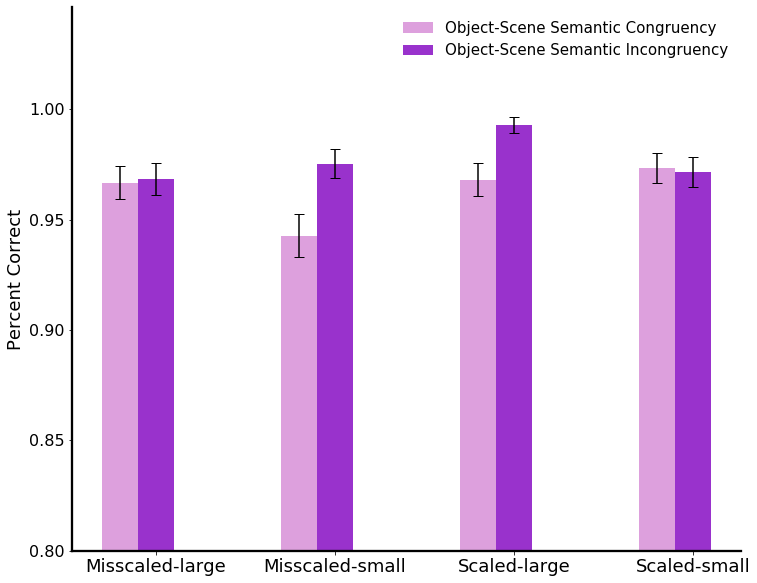

In [16]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

#                                          Misscaled                                               Scaled
#                                large                          small                         large                       small
Acc_objSemCong =   [misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_acc, scaled_zi_objSemCong_acc]
yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

# yerr_objSemCong =  [0.03042634, 0.009242794, 0.009306265, 0.022845975]

Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_acc]
yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

# yerr_objSemIncong =  [0.027580192, 0.011109077, 0.008396171, 0.031121827]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=yerr_objSemIncong, capsize=5)


plt.xticks(x, ['Misscaled-large', 'Misscaled-small', 'Scaled-large', 'Scaled-small'], fontsize='18')
plt.ylim(0.80)
plt.yticks(fontsize=16) 
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15, frameon=False)
# plt.title('E5V2-Accuracy', fontsize=22)
plt.show()

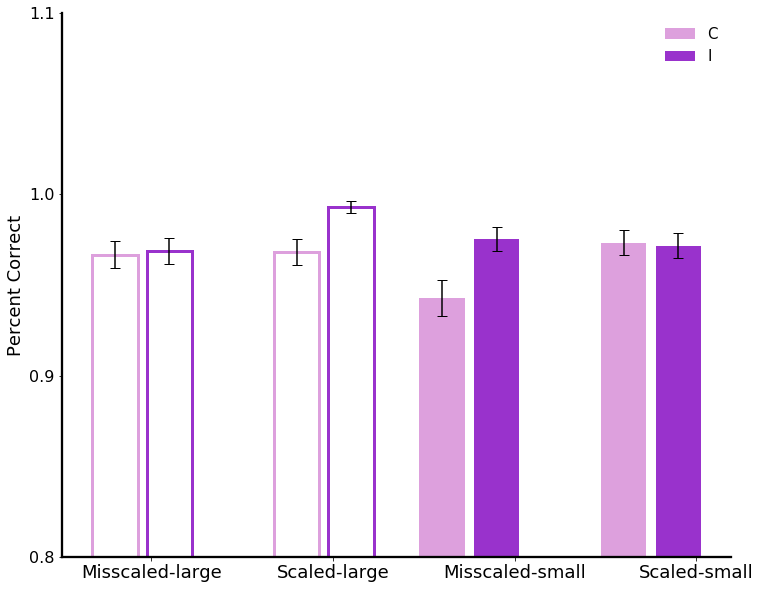

In [93]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

#                                          Large                                               Small
#                                ms                          s                         ms                       s
Acc_objSemCong =   [misscaled_zo_objSemCong_acc, scaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zi_objSemCong_acc]
yerr_objSemCong =  [misscaled_zo_objSemCong_sem, scaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zi_objSemCong_sem]


Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, scaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zi_objSemIncong_acc]
yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, scaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zi_objSemIncong_sem]


width = 0.25
  
group_offset = 0.1  # Increase this value to move groups further apart

# Adjust the positions
x_adj = x + np.repeat([group_offset, -group_offset], 2)

# Plot bars with filled color for 'Misscaled-small', 'Scaled-small'
plt.bar(x_adj[2:]-0.3, Acc_objSemCong[2:], width, color='plum', label='C', yerr=yerr_objSemCong[2:], capsize=5)
plt.bar(x_adj[2:], Acc_objSemIncong[2:], width, color='darkorchid', label='I', yerr=yerr_objSemIncong[2:], capsize=5)

# Plot bars with no fill color (just outline) for 'Misscaled-large', 'Scaled-large'
plt.bar(x_adj[:2]-0.3, Acc_objSemCong[:2], width, edgecolor='plum', linewidth=3, facecolor='none', yerr=yerr_objSemCong[:2], capsize=5)
plt.bar(x_adj[:2], Acc_objSemIncong[:2], width, edgecolor='darkorchid', linewidth=3, facecolor='none', yerr=yerr_objSemIncong[:2], capsize=5)

plt.xticks(x, ['Misscaled-large', 'Scaled-large', 'Misscaled-small', 'Scaled-small'], fontsize='18')
plt.ylim(0.80, 1)
plt.yticks(np.arange(0.8, 1.1, .1), fontsize=16)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15, frameon=False)

plt.savefig(fig_destination + '/exp1-acc-scale-x-OSS-x-pS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

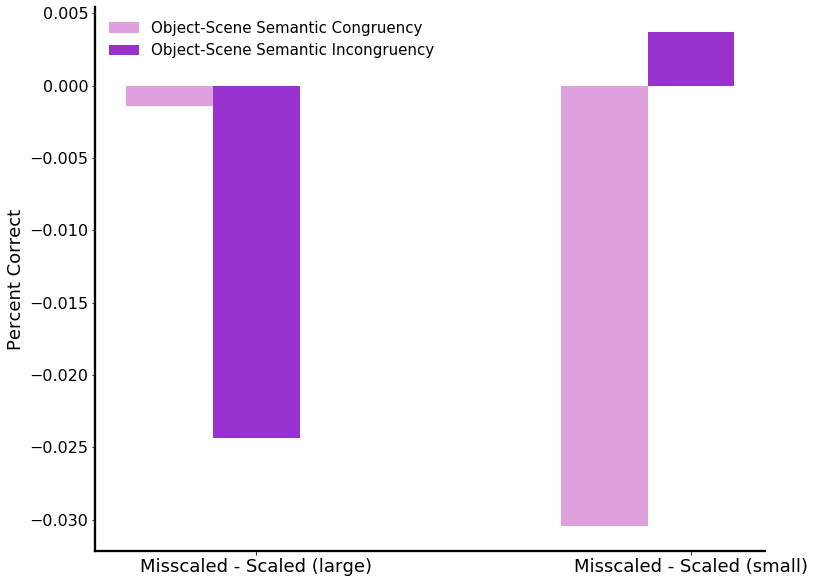

In [14]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

Acc_objSemCong =   [misscaled_zo_objSemCong_acc - scaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc - scaled_zi_objSemCong_acc]
# yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

# yerr_objSemCong =  [0.03042634, 0.009242794, 0.009306265, 0.022845975]

Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc - scaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc - scaled_zi_objSemIncong_acc]
# yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

# yerr_objSemIncong =  [0.027580192, 0.011109077, 0.008396171, 0.031121827]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', capsize=5)


plt.xticks(x, ['Misscaled - Scaled (large)', 'Misscaled - Scaled (small)'], fontsize='18')
# plt.ylim(0.80)
plt.yticks(fontsize=16) 
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=0, fontsize=15, frameon=False)
# plt.title('E5V2-Accuracy', fontsize=22)
plt.show()

In [15]:
small_acc_diffs_objSC = []
small_acc_diffs_objSIC = []

for scene in zi_df['scene'].unique():
    scene_df = zi_df.loc[zi_df['scene']==scene]
    scene_df_objSC = scene_df.loc[scene_df['objSceneSemCong']==1]
    scene_df_objSIC = scene_df.loc[scene_df['objSceneSemCong']==0]
    
    # 0
    scene_df_objSC_ms = scene_df_objSC.loc[scene_df_objSC['scale']=='misscaled']
    # 1
    scene_df_objSC_s = scene_df_objSC.loc[scene_df_objSC['scale']=='scaled']
    # 2
    scene_df_objSIC_ms = scene_df_objSIC.loc[scene_df_objSIC['scale']=='misscaled']
    # 3
    scene_df_objSIC_s = scene_df_objSIC.loc[scene_df_objSIC['scale']=='scaled']
    
    acc_0 = np.sum(np.array(scene_df_objSC_ms['accuracy']))/len(np.array(scene_df_objSC_ms['accuracy']))
    acc_1 = np.sum(np.array(scene_df_objSC_s['accuracy']))/len(np.array(scene_df_objSC_s['accuracy']))
    acc_2 = np.sum(np.array(scene_df_objSIC_ms['accuracy']))/len(np.array(scene_df_objSIC_ms['accuracy']))
    acc_3 = np.sum(np.array(scene_df_objSIC_s['accuracy']))/len(np.array(scene_df_objSIC_s['accuracy']))
    
    # 0 - 1
    diff_objSC = acc_0 - acc_1
    # 2 - 3
    diff_objSIC = acc_2 - acc_3
    
    small_acc_diffs_objSC.append(diff_objSC)
    small_acc_diffs_objSIC.append(diff_objSIC)
    
small_sem_diffs_objSC = stats.sem(small_acc_diffs_objSC)
small_sem_diffs_objSIC = stats.sem(small_acc_diffs_objSIC)

In [16]:
large_acc_diffs_objSC = []
large_acc_diffs_objSIC = []

for scene in zo_df['scene'].unique():
    scene_df = zo_df.loc[zo_df['scene']==scene]
    scene_df_objSC = scene_df.loc[scene_df['objSceneSemCong']==1]
    scene_df_objSIC = scene_df.loc[scene_df['objSceneSemCong']==0]
    
    # 0
    scene_df_objSC_ms = scene_df_objSC.loc[scene_df_objSC['scale']=='misscaled']
    # 1
    scene_df_objSC_s = scene_df_objSC.loc[scene_df_objSC['scale']=='scaled']
    # 2
    scene_df_objSIC_ms = scene_df_objSIC.loc[scene_df_objSIC['scale']=='misscaled']
    # 3
    scene_df_objSIC_s = scene_df_objSIC.loc[scene_df_objSIC['scale']=='scaled']
    
    acc_0 = np.sum(np.array(scene_df_objSC_ms['accuracy']))/len(np.array(scene_df_objSC_ms['accuracy']))
    acc_1 = np.sum(np.array(scene_df_objSC_s['accuracy']))/len(np.array(scene_df_objSC_s['accuracy']))
    acc_2 = np.sum(np.array(scene_df_objSIC_ms['accuracy']))/len(np.array(scene_df_objSIC_ms['accuracy']))
    acc_3 = np.sum(np.array(scene_df_objSIC_s['accuracy']))/len(np.array(scene_df_objSIC_s['accuracy']))
    
    # 0 - 1
    diff_objSC = acc_0 - acc_1
    # 2 - 3
    diff_objSIC = acc_2 - acc_3
    
    large_acc_diffs_objSC.append(diff_objSC)
    large_acc_diffs_objSIC.append(diff_objSIC)
    
large_sem_diffs_objSC = stats.sem(large_acc_diffs_objSC)
large_sem_diffs_objSIC = stats.sem(large_acc_diffs_objSIC)

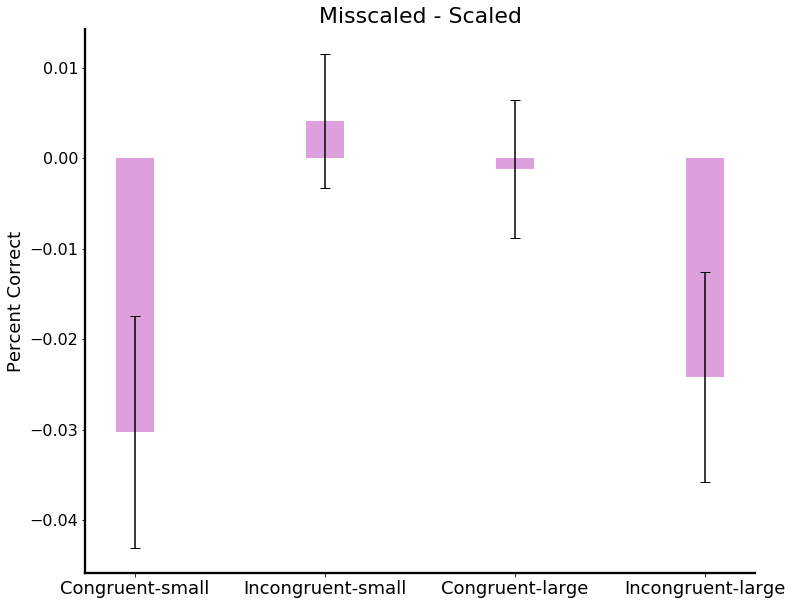

In [17]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
    
diffs = [np.mean(np.array(small_acc_diffs_objSC)), np.mean(np.array(small_acc_diffs_objSIC)), np.mean(np.array(large_acc_diffs_objSC)), np.mean(np.array(large_acc_diffs_objSIC))]
sem_diffs = [small_sem_diffs_objSC, small_sem_diffs_objSIC, large_sem_diffs_objSC, large_sem_diffs_objSIC]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, diffs, width, color='plum', yerr=sem_diffs, capsize=5)


plt.xticks(x, ['Congruent-small', 'Incongruent-small', 'Congruent-large', 'Incongruent-large'], fontsize='18')
# plt.ylim(0.80)
plt.yticks(fontsize=16) 
plt.ylabel("Percent Correct", fontsize=18)
# plt.legend(loc=1, fontsize=15, frameon=False)
plt.title('Misscaled - Scaled', fontsize=22)
plt.show()

## RT: Correct only 

In [98]:
final_data_correctOnly = final_data.loc[final_data['accuracy']==1]

np.mean(np.array(final_data_correctOnly['RT']))

1702.138769021122

In [99]:
final_data_CO_renamed = final_data_correctOnly.rename(columns={'Z-Scored RT': 'zsRT'})


In [72]:
final_data_CO_renamed.to_csv('visual-search-CO-data.csv', index=False)

In [100]:
# data split by object-scene size congruency aka scene zoom 

col = 'Z-Scored RT'

zo_df_CO = final_data_correctOnly.loc[final_data_correctOnly['presentationSize']=='large']
zi_df_CO = final_data_correctOnly.loc[final_data_correctOnly['presentationSize']=='small']

zo_RT = np.mean(np.array(zo_df_CO[col]))
zi_RT = np.mean(np.array(zi_df_CO[col]))


zo_RT_sem = sem(np.array(zo_df_CO[col]))
zi_RT_sem = sem(np.array(zi_df_CO[col]))


zo_RT, zi_RT

(-0.14752670490250266, 0.1231008688002906)

In [66]:
print("Paired T-Test: Large vs Small Presentation Size")

main_ttest(100, zo_df_CO[col].to_list(), zi_df_CO[col].to_list())

Paired T-Test: Large vs Small Presentation Size


(-9.297686014683137, 8.14586581633981e-20)

In [101]:
ms_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scale']=='misscaled']
s_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scale']=='scaled']

ms_RT = np.mean(np.array(ms_df_CO[col]))
s_RT = np.mean(np.array(s_df_CO[col]))


ms_RT_sem = sem(np.array(ms_df_CO[col]))
s_RT_sem = sem(np.array(s_df_CO[col]))


print("Paired T-Test: Misscaled vs Scaled")

main_ttest(100, ms_df_CO[col].to_list(), s_df_CO[col].to_list())

Paired T-Test: Misscaled vs Scaled


(3.736045674248956, 0.00019916337234882967)

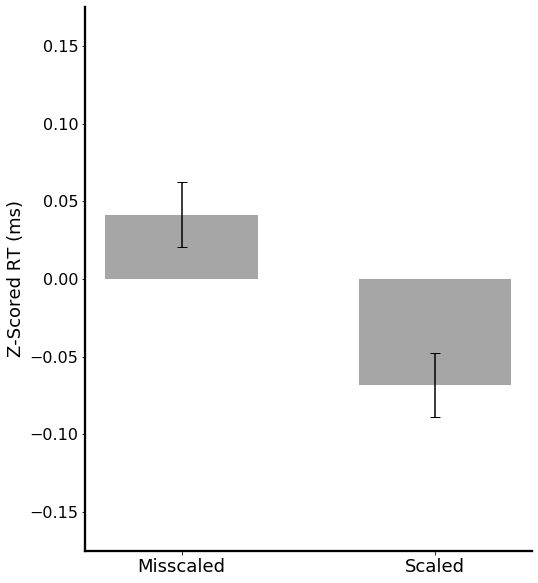

In [102]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Misscaled':ms_RT, 'Scaled':s_RT}

courses = list(data.keys())
values = list(data.values())
   
# creating the bar plot
# plt.bar(courses, values, color ='lightcoral', alpha=0.7,
#         width = 0.4, yerr=[12.22398389, 12.22398389], capsize=5)

plt.bar(courses, values, color ='gray', alpha=0.7,
        width = 0.6, yerr=[ms_RT_sem, s_RT_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.ylim(-0.175, 0.175)
plt.yticks(fontsize=16) 
if col == 'Z-Scored RT':
    # plt.ylim(1000)
    plt.ylabel("Z-Scored RT (ms)", fontsize=18)
else:
    plt.ylim(1000)
    plt.ylabel("RT (ms)", fontsize=18)
    
plt.savefig(fig_destination + '/exp1-RT-scale.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution
plt.show()

## Effect of Scale by Objects

In [26]:
objects = final_data_correctOnly.object.unique()

In [27]:
def get_RT_byScale(df, col):
    '''
    Args:
        Unfiltered df
        col - specify if z-scored or raw trial RT 

    Returns:
        dict of RT results for scaled and misscaled 
    
    '''
    results = {}
    # misscaled
    ms_df = df.loc[df['scale']=='misscaled']
    results['misscaled'] = [np.mean(np.array(ms_df[col])), sem(np.array(ms_df[col]))]
    # scaled
    s_df = df.loc[df['scale']=='scaled']
    results['scaled'] = [np.mean(np.array(s_df[col])), sem(np.array(s_df[col]))]

    return results

In [30]:
# Misscaled
ms_objects_avgRT = {}
ms_objects_semRT = {}
# Scaled
s_objects_avgRT = {}
s_objects_semRT = {}

for obj in objects:
    obj_df = final_data_correctOnly.loc[final_data_correctOnly['object']==obj]
    obj_RT_results = get_RT_byScale(obj_df, col)
    # add to appropriate dictionary
    ms_objects_avgRT[obj] = obj_RT_results['misscaled'][0]
    ms_objects_semRT[obj] = obj_RT_results['misscaled'][1]

    s_objects_avgRT[obj] = obj_RT_results['scaled'][0]
    s_objects_semRT[obj] = obj_RT_results['scaled'][1]


ms_objects_avgRT

{'pot': 0.14057328328745666,
 'flashdrive': 0.07270963631831788,
 'eraser': -0.2015633128613205,
 'saltshaker': -0.16275026992470823,
 'binderclip': -0.03735440106836621,
 'notebook': 0.15747011727688695,
 'spoon': 0.06578443953689744,
 'sponge': -0.42955359629109335,
 'clipboard': 0.41783200997353115,
 'kettle': 0.28408514103643967,
 'toaster': -0.08683330566981837,
 'laptop': 0.3254970345436071}

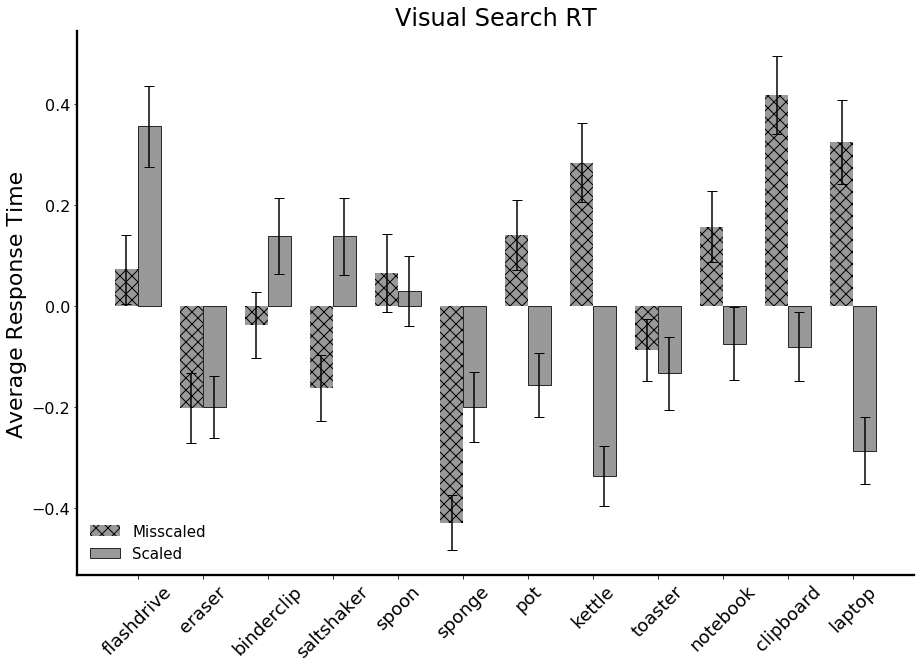

In [59]:
fig, ax = plt.subplots(figsize=[15,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# Convert dictionaries to lists for plotting
objects_labels = ['flashdrive', 'eraser', 'binderclip', 'saltshaker', 'spoon', 'sponge', 'pot', 'kettle', 'toaster', 'notebook', 'clipboard', 'laptop', ]
ms_avgRT = [ms_objects_avgRT[obj] for obj in objects_labels]
ms_semRT = [ms_objects_semRT[obj] for obj in objects_labels]
s_avgRT = [s_objects_avgRT[obj] for obj in objects_labels]
s_semRT = [s_objects_semRT[obj] for obj in objects_labels]

# X locations for the groups
ind = np.arange(len(objects_labels))
width = 0.35  # Width of the bars

rects1 = ax.bar(ind - width/2, ms_avgRT, width, yerr=ms_semRT, label='Misscaled', capsize=5, alpha=0.8, color='gray', hatch='xx')
rects2 = ax.bar(ind + width/2, s_avgRT, width, yerr=s_semRT, label='Scaled', capsize=5, alpha=0.8, color='gray',  edgecolor='black')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Average Response Time', fontsize=22)
ax.set_xticks(ind)
ax.set_xticklabels(objects_labels, rotation=45)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16) 

plt.legend(loc=0, fontsize=15, frameon=False)
plt.title('Visual Search RT', fontsize=24)

plt.show()

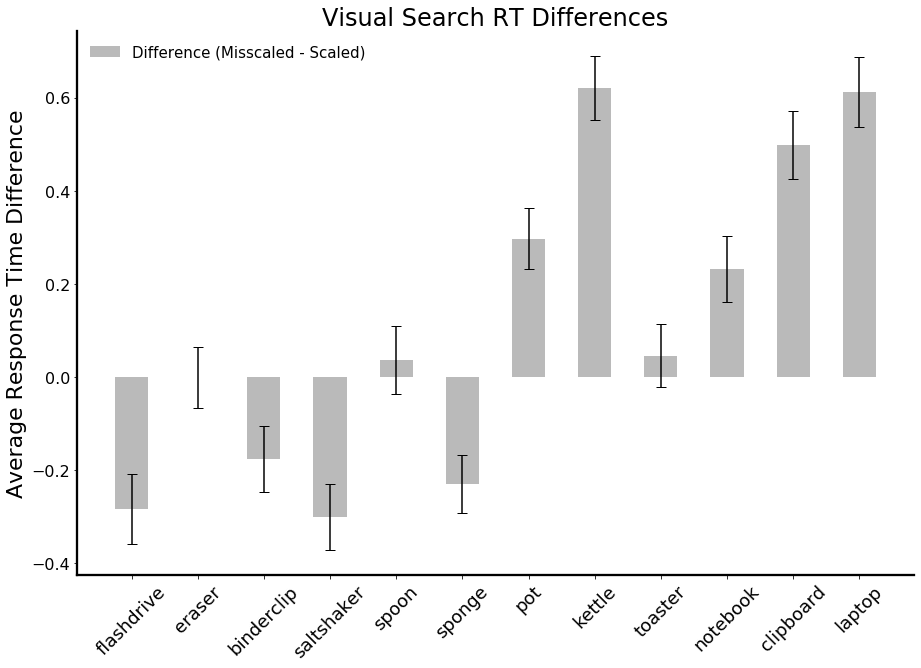

In [64]:
fig, ax = plt.subplots(figsize=[15,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# Convert dictionaries to lists for plotting
objects_labels = ['flashdrive', 'eraser', 'binderclip', 'saltshaker', 'spoon', 'sponge', 'pot', 'kettle', 'toaster', 'notebook', 'clipboard', 'laptop']

# Calculate differences and average SEMs
diff_avgRT = [ms - s for ms, s in zip(ms_avgRT, s_avgRT)]
avg_semRT = [(ms_sem + s_sem) / 2 for ms_sem, s_sem in zip(ms_semRT, s_semRT)]

# X locations for the objects
ind = np.arange(len(objects_labels))
width = 0.5  # Adjusted width for a single set of bars

# Plotting the differences with averaged SEMs
ax.bar(ind, diff_avgRT, width, yerr=avg_semRT, label='Difference (Misscaled - Scaled)', capsize=5, alpha=0.8, color='darkgray')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Average Response Time Difference', fontsize=22)
ax.set_xticks(ind)
ax.set_xticklabels(objects_labels, rotation=45, fontsize=18)
ax.set_title('Visual Search RT Differences', fontsize=24)

plt.yticks(fontsize=16)
plt.legend(loc=0, fontsize=15, frameon=False)

plt.show()


### Obj-Scene Sem Cong

In [32]:
final_data_correctOnly.objSceneSemCong.unique()

array([1, 0])

In [19]:
incong_df_CO = final_data_correctOnly.loc[final_data_correctOnly['objSceneSemCong']==0]
cong_df_CO = final_data_correctOnly.loc[final_data_correctOnly['objSceneSemCong']==1]

incong_RT = np.mean(np.array(incong_df_CO[col]))
cong_RT = np.mean(np.array(cong_df_CO[col]))


incong_RT_sem = sem(np.array(incong_df_CO[col]))
cong_RT_sem = sem(np.array(cong_df_CO[col]))

print(incong_RT, cong_RT)

-0.043436555779434255 0.01694421467530669


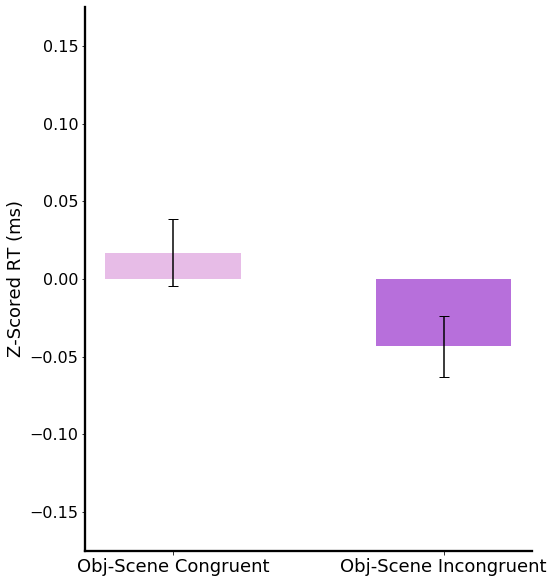

In [10]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Obj-Scene Congruent':cong_RT, 'Obj-Scene Incongruent':incong_RT, }

courses = list(data.keys())
values = list(data.values())
   
# creating the bar plot

colors = ['plum', 'darkorchid']  # Specifying colors for each bar
plt.bar(courses, values, color=colors, alpha=0.7, width=0.5, yerr=[cong_RT_sem, incong_RT_sem], capsize=5)



plt.xticks(fontsize=18) 
plt.ylim(-0.175, 0.175)

plt.yticks(fontsize=16) 
if col == 'Z-Scored RT':
    # plt.ylim(1000)
    plt.ylabel("Z-Scored RT (ms)", fontsize=18)
else:
    plt.ylim(1000)
    plt.ylabel("RT (ms)", fontsize=18)
    
plt.savefig(fig_destination + '/exp1-RT-OSS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution
plt.show()

In [83]:
final_data_correctOnly.presentationSize.unique()

array(['small', 'large'], dtype=object)

True

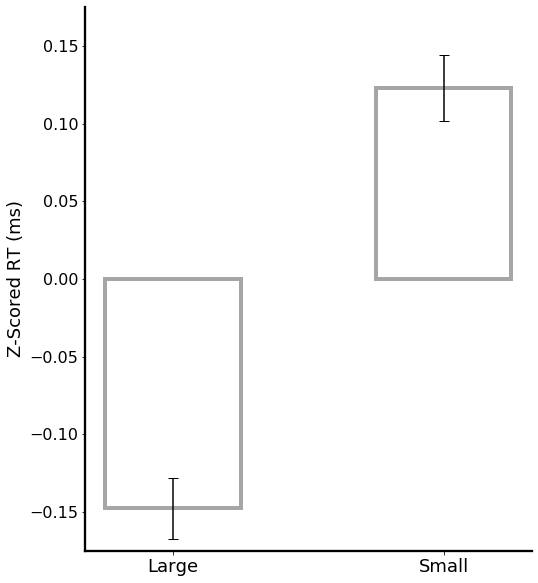

In [118]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Large':zo_RT, 'Small':zi_RT}

courses = list(data.keys())
values = list(data.values())
   
# creating the bar plot
# plt.bar(courses, values, color ='lightcoral', alpha=0.7,
#         width = 0.4, yerr=[12.22398389, 12.22398389], capsize=5)

plt.bar(courses, values, color = 'white', edgecolor ='gray', linewidth=4, alpha=0.7,
        width = 0.5, yerr=[zo_RT_sem, zi_RT_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.ylim(-0.175, 0.175)
plt.yticks(fontsize=16) 

if col == 'Z-Scored RT':
    # plt.ylim(1000)
    plt.ylabel("Z-Scored RT (ms)", fontsize=18)
else:
    plt.ylim(1000)
    plt.ylabel("RT (ms)", fontsize=18)
    
plt.savefig(fig_destination + '/exp1-RT-pS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution
plt.show()

In [14]:
misscaled_zo_CO = zo_df_CO.loc[zo_df_CO['scale'] =='misscaled'] 
misscaled_zi_CO = zi_df_CO.loc[zi_df_CO['scale'] =='misscaled']
misscaled_CO = misscaled_zo_CO.append(misscaled_zi_CO)

scaled_zo_CO = zo_df_CO.loc[zo_df_CO['scale'] =='scaled'] 
scaled_zi_CO = zi_df_CO.loc[zi_df_CO['scale'] =='scaled']
scaled_CO = scaled_zo_CO.append(scaled_zi_CO)

### Scale x ObjSceneSemCong

In [109]:
ms_osC = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 1) & (final_data_correctOnly['scale'] == 'misscaled')]
ms_osI = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 0) & (final_data_correctOnly['scale'] == 'misscaled')]

s_osC = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 1) & (final_data_correctOnly['scale'] == 'scaled')]
s_osI = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 0) & (final_data_correctOnly['scale'] == 'scaled')]

In [112]:
col

'Z-Scored RT'

In [115]:
import scipy.stats as stats

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(np.array(ms_osC[col]), np.array(ms_osI[col]), np.array(s_osC[col]), np.array(s_osI[col]))
f_value, p_value

(6.823718139069938, 0.00013850567981620583)

In [117]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform two-way ANOVA
model = ols('zsRT ~ C(objSceneSemCong) + C(scale) + C(objSceneSemCong):C(scale)', data=final_data_CO_renamed).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)


                                  sum_sq      df          F    PR(>F)
C(objSceneSemCong)              4.043233     1.0   4.303386  0.038095
C(scale)                       13.280587     1.0  14.135097  0.000172
C(objSceneSemCong):C(scale)     1.940407     1.0   2.065258  0.150761
Residual                     4133.067220  4399.0        NaN       NaN


In [107]:
print('Mis-scaled: Incong vs Cong')
main_ttest(10000, ms_osC[col].to_list(), ms_osI[col].to_list())

Mis-scaled: Incong vs Cong


(2.4525920710557902, 0.01500150278503187)

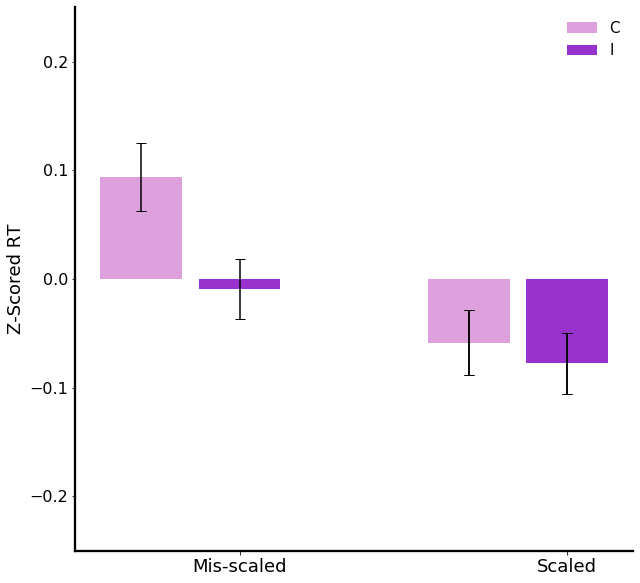

In [106]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

            #            Mis-scaled                 Scaled
Y0 =   [np.mean(np.array(ms_osC[col])), np.mean(np.array(s_osC[col]))]
yerr_Y0 =  [sem(np.array(ms_osC[col])), sem(np.array(s_osC[col]))]


Y1 =   [np.mean(np.array(ms_osI[col])), np.mean(np.array(s_osI[col]))]
yerr_Y1 =  [sem(np.array(ms_osI[col])), sem(np.array(s_osI[col]))]


width = 0.25
  
# Plot 'Large' category bars with just color outlines
plt.bar(x-0.3, Y0, width, color='plum', label='C', yerr=yerr_Y0, capsize=5, linewidth=3)
plt.bar(x[1]-0.3, Y0[1], width, color='plum', label='_nolegend_', yerr=yerr_Y0[1], capsize=5)  # Small, Congruent

plt.bar(x, Y1, width, color='darkorchid', label='I', yerr=yerr_Y1, capsize=5, linewidth=3)
plt.bar(x[1], Y1[1], width, color='darkorchid', label='_nolegend_', yerr=yerr_Y1[1], capsize=5)  # Small, Incongruent



plt.xticks(x, ['Mis-scaled', 'Scaled'], fontsize='18')
plt.ylim(-0.25,.25)
plt.yticks(fontsize=16) 
plt.ylabel("Z-Scored RT", fontsize=18)
plt.legend(loc=0, fontsize=15, frameon=False)

plt.savefig(fig_destination + '/EXP1-RT.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

### Presentation size x ObjSceneSemCong

In [15]:
large_osC = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 1) & (final_data_correctOnly['presentationSize'] == 'large')]
large_osI = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 0) & (final_data_correctOnly['presentationSize'] == 'large')]

small_osC = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 1) & (final_data_correctOnly['presentationSize'] == 'small')]
small_osI = final_data_correctOnly[(final_data_correctOnly['objSceneSemCong'] == 0) & (final_data_correctOnly['presentationSize'] == 'small')]

In [110]:
print('Large: Incong vs Cong')
main_ttest(10000, large_osC[col].to_list(), large_osI[col].to_list())

Large: Incong vs Cong


NameError: name 'main_ttest' is not defined

In [100]:
print('Small: Incong vs Cong')
main_ttest(10000, small_osC[col].to_list(), small_osI[col].to_list())

Small: Incong vs Cong


(3.1707065234759955, 0.001687292579888047)

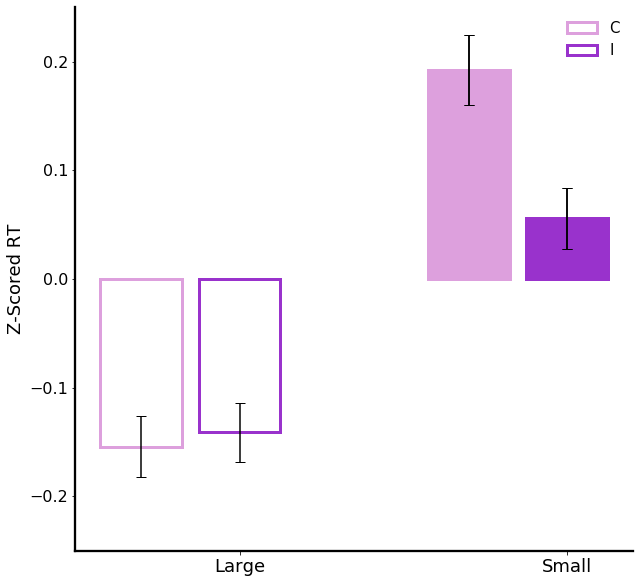

In [124]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

#            Large               Small
Y0 =   [np.mean(np.array(large_osC[col])), np.mean(np.array(small_osC[col]))]
yerr_Y0 =  [sem(np.array(large_osC[col])), sem(np.array(small_osC[col]))]


Y1 =   [np.mean(np.array(large_osI[col])), np.mean(np.array(small_osI[col]))]
yerr_Y1 =  [sem(np.array(large_osI[col])), sem(np.array(small_osI[col]))]


width = 0.25
  
# Plot 'Large' category bars with just color outlines
plt.bar(x-0.3, Y0, width, edgecolor='plum', facecolor='none', label='C', yerr=yerr_Y0, capsize=5, linewidth=3)
# Then plot 'Small' category normally
plt.bar(x[1]-0.3, Y0[1], width, color='plum', label='_nolegend_', yerr=yerr_Y0[1], capsize=5)  # Small, Congruent

plt.bar(x, Y1, width, edgecolor='darkorchid', facecolor='none', label='I', yerr=yerr_Y1, capsize=5, linewidth=3)
# Then plot 'Small' category normally
plt.bar(x[1], Y1[1], width, color='darkorchid', label='_nolegend_', yerr=yerr_Y1[1], capsize=5)  # Small, Incongruent



plt.xticks(x, ['Large', 'Small'], fontsize='18')
plt.ylim(-0.25,.25)
plt.yticks(fontsize=16) 
plt.ylabel("Z-Scored RT", fontsize=18)
plt.legend(loc=0, fontsize=15, frameon=False)

plt.savefig(fig_destination + '/exp1-RT-pS-OSS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

### Complete RT Plot

In [16]:
misscaled_zo_objSemCong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objSceneSemCong"]==1]
misscaled_zo_objSemIncong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objSceneSemCong"]==0]

misscaled_zo_objSemCong_RT = np.mean(np.array(misscaled_zo_objSemCong_CO[col]))
misscaled_zo_objSemIncong_RT = np.mean(np.array(misscaled_zo_objSemIncong_CO[col]))

misscaled_zo_objSemCong_RT_sem = sem(np.array(misscaled_zo_objSemCong_CO[col]))
misscaled_zo_objSemIncong_RT_sem = sem(np.array(misscaled_zo_objSemIncong_CO[col]))


misscaled_zi_objSemCong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objSceneSemCong"]==1]
misscaled_zi_objSemIncong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objSceneSemCong"]==0]

misscaled_zi_objSemCong_RT = np.mean(np.array(misscaled_zi_objSemCong_CO[col]))
misscaled_zi_objSemIncong_RT = np.mean(np.array(misscaled_zi_objSemIncong_CO[col]))

misscaled_zi_objSemCong_RT_sem = sem(np.array(misscaled_zi_objSemCong_CO[col]))
misscaled_zi_objSemIncong_RT_sem = sem(np.array(misscaled_zi_objSemIncong_CO[col]))


# scaled
scaled_zo_objSemCong_CO = scaled_zo_CO.loc[scaled_zo_CO["objSceneSemCong"]==1]
scaled_zo_objSemIncong_CO = scaled_zo_CO.loc[scaled_zo_CO["objSceneSemCong"]==0]

scaled_zo_objSemCong_RT = np.mean(np.array(scaled_zo_objSemCong_CO[col]))
scaled_zo_objSemIncong_RT = np.mean(np.array(scaled_zo_objSemIncong_CO[col]))

scaled_zo_objSemCong_RT_sem = sem(np.array(scaled_zo_objSemCong_CO[col]))
scaled_zo_objSemIncong_RT_sem = sem(np.array(scaled_zo_objSemIncong_CO[col]))


scaled_zi_objSemCong_CO = scaled_zi_CO.loc[scaled_zi_CO["objSceneSemCong"]==1]
scaled_zi_objSemIncong_CO = scaled_zi_CO.loc[scaled_zi_CO["objSceneSemCong"]==0]

scaled_zi_objSemCong_RT = np.mean(np.array(scaled_zi_objSemCong_CO[col]))
scaled_zi_objSemIncong_RT = np.mean(np.array(scaled_zi_objSemIncong_CO[col]))

scaled_zi_objSemCong_RT_sem = sem(np.array(scaled_zi_objSemCong_CO[col]))
scaled_zi_objSemIncong_RT_sem = sem(np.array(scaled_zi_objSemIncong_CO[col]))


In [12]:
import scipy.stats as stats
from random import sample

ms_large_osC = misscaled_zo_objSemCong_CO[col].to_list()
ms_large_osI = misscaled_zo_objSemIncong_CO[col].to_list()
ms_small_osC = misscaled_zi_objSemCong_CO[col].to_list()
ms_small_osI = misscaled_zi_objSemIncong_CO[col].to_list()

s_large_osC = scaled_zo_objSemCong_CO[col].to_list()
s_large_osI = scaled_zo_objSemIncong_CO[col].to_list()
s_small_osC = scaled_zi_objSemCong_CO[col].to_list()
s_small_osI = scaled_zi_objSemIncong_CO[col].to_list()


print('Misscaled small: ObjSceneCong x ObjSceneIncong')
print(main_ttest(1000, ms_small_osC, ms_small_osI))

print()

print('Scaled small: ObjSceneCong x ObjSceneIncong')
print(main_ttest(1000, s_small_osC, s_small_osI))

print()

print('ObjSceneCong small: Misscaled x Scaled')
print(main_ttest(1000, ms_small_osC, s_small_osC))

print()

print('ObjSceneIncong small: Misscaled x Scaled')
print(main_ttest(1000, ms_small_osI, s_small_osI))

print()

#large
print('Misscaled large: ObjSceneCong x ObjSceneIncong')
print(main_ttest(1000, ms_large_osC, ms_large_osI))

print()
print('Scaled large: ObjSceneCong x ObjSceneIncong')
print(main_ttest(1000, s_large_osC, s_large_osI))

print()
print('ObjSceneCong large: Misscaled x Scaled')
print(main_ttest(1000, ms_large_osC, s_large_osC))

print()

print('ObjSceneIncong large: Misscaled x Scaled')
print(main_ttest(1000, ms_large_osI, s_large_osI))


NameError: name 'misscaled_zo_objSemCong_CO' is not defined

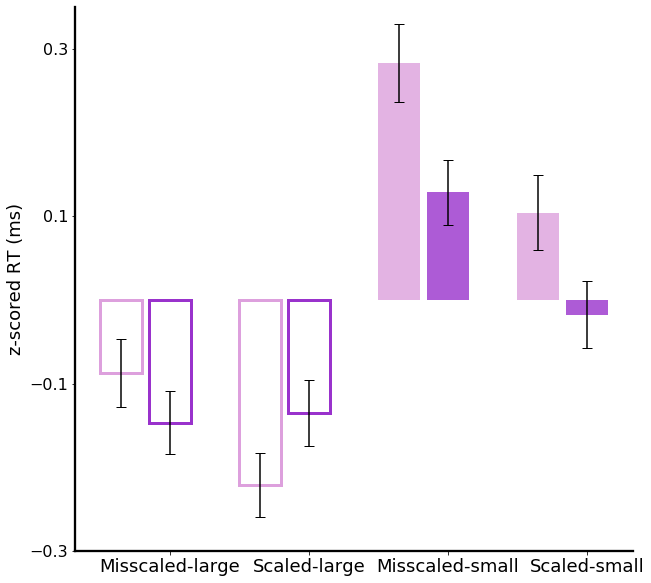

In [26]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

#                                          Misscaled                                             Scaled
#                               large                          small                         large                     small

RT_objSemCong =   [misscaled_zo_objSemCong_RT, scaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]


RT_objSemIncong = [misscaled_zo_objSemIncong_RT, scaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, misscaled_zi_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]





width = 0.3
  
# Plot 'Misscaled-small' and 'Scaled-small' normally
plt.bar(x[2:]-0.35, RT_objSemCong[2:], width, color='plum', yerr=RT_objSemCong_sem[2:], capsize=5, alpha=0.8, label='Object-Scene Semantic Congruency')
plt.bar(x[2:], RT_objSemIncong[2:], width, color='darkorchid', yerr=RT_objSemIncong_sem[2:], capsize=5, alpha=0.8, label='Object-Scene Semantic Incongruency')

# Plot 'Misscaled-large' and 'Scaled-large' with no fill, just colored outlines
for i in range(2):
    plt.bar(x[i]-0.35, RT_objSemCong[i], width, edgecolor='plum', facecolor='none', linewidth=3, yerr=RT_objSemCong_sem[i], capsize=5, label='Object-Scene Semantic Congruency' if i==0 else "_nolegend_")
    plt.bar(x[i], RT_objSemIncong[i], width, edgecolor='darkorchid', facecolor='none', linewidth=3, yerr=RT_objSemIncong_sem[i], capsize=5, label='Object-Scene Semantic Incongruency' if i==0 else "_nolegend_")

plt.xticks(x, ['Misscaled-large', 'Scaled-large', 'Misscaled-small', 'Scaled-small'], fontsize='18')
plt.ylim(-0.3, 0.35)
plt.yticks(np.arange(-0.3, 0.45, 0.2), fontsize=16)
plt.ylabel("z-scored RT (ms)", fontsize=18)
# plt.legend(loc=0, fontsize=15, frameon=False)

plt.savefig(fig_destination + '/exp1-RT-pS-scale-OSS.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

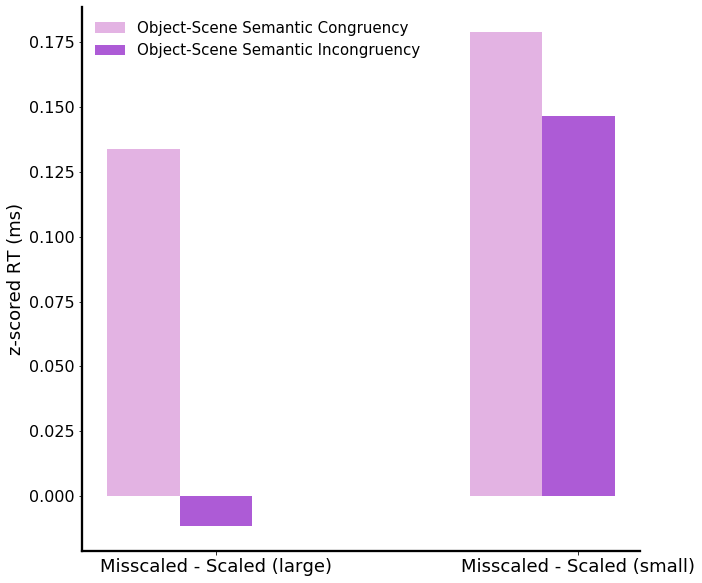

In [72]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

d_RT_objSemCong =   [misscaled_zo_objSemCong_RT- scaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT - scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
d_RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem - scaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem - scaled_zi_objSemCong_RT_sem]


d_RT_objSemIncong = [misscaled_zo_objSemIncong_RT - scaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT - scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
d_RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem - scaled_zo_objSemIncong_RT_sem, misscaled_zi_objSemIncong_RT_sem - scaled_zi_objSemIncong_RT_sem]





width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, d_RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', capsize=5, alpha=0.8)
plt.bar(x, d_RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled - Scaled (large)', 'Misscaled - Scaled (small)'], fontsize='18')
# plt.ylim(-0.4, 0.3)
plt.yticks(fontsize=16) 
plt.ylabel("z-scored RT (ms)", fontsize=18)
plt.legend(loc=2, fontsize=15, frameon=False)
# plt.title('E5V2-RT', fontsize=22)
plt.show()

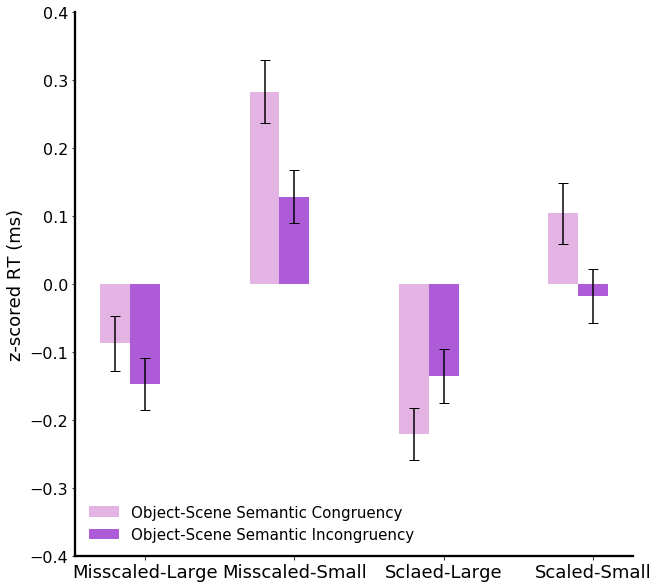

In [58]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_objSemCong =   [misscaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zo_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]


RT_objSemIncong = [misscaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zo_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem,  misscaled_zi_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]





width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled-Large', 'Misscaled-Small', 'Sclaed-Large',  'Scaled-Small'], fontsize='18')
plt.ylim(-0.4, 0.3)
plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
plt.ylabel("z-scored RT (ms)", fontsize=18)
plt.legend(loc=3, fontsize=15, frameon=False)
# plt.figtext(0.99, 0.01, 'footnote text', horizontalalignment='center')
# plt.title('E5V2-RT', fontsize=22)
plt.show()

In [60]:
small_RT_diffs_objSC = []
small_RT_diffs_objSIC = []

for scene in zi_df['scene'].unique():
    scene_df = zi_df.loc[zi_df['scene']==scene]
    scene_df_objSC = scene_df.loc[scene_df['objSceneSemCong']==1]
    scene_df_objSIC = scene_df.loc[scene_df['objSceneSemCong']==0]
    
    # 0
    scene_df_objSC_ms = scene_df_objSC.loc[scene_df_objSC['scale']=='misscaled']
    # 1
    scene_df_objSC_s = scene_df_objSC.loc[scene_df_objSC['scale']=='scaled']
    # 2
    scene_df_objSIC_ms = scene_df_objSIC.loc[scene_df_objSIC['scale']=='misscaled']
    # 3
    scene_df_objSIC_s = scene_df_objSIC.loc[scene_df_objSIC['scale']=='scaled']
    
    RT_0 = np.mean(np.array(scene_df_objSC_ms['Z-Scored RT']))
    RT_1 = np.mean(np.array(scene_df_objSC_s['Z-Scored RT']))
    RT_2 = np.mean(np.array(scene_df_objSIC_ms['Z-Scored RT']))
    RT_3 = np.mean(np.array(scene_df_objSIC_s['Z-Scored RT']))
    
    # 0 - 1
    diff_objSC = RT_0 - RT_1
    # 2 - 3
    diff_objSIC = RT_2 - RT_3
    
    small_RT_diffs_objSC.append(diff_objSC)
    small_RT_diffs_objSIC.append(diff_objSIC)
    
small_RT_sem_diffs_objSC = stats.sem(small_RT_diffs_objSC)
small_RT_sem_diffs_objSIC = stats.sem(small_RT_diffs_objSIC)

In [61]:
large_RT_diffs_objSC = []
large_RT_diffs_objSIC = []

for scene in zo_df['scene'].unique():
    scene_df = zo_df.loc[zo_df['scene']==scene]
    scene_df_objSC = scene_df.loc[scene_df['objSceneSemCong']==1]
    scene_df_objSIC = scene_df.loc[scene_df['objSceneSemCong']==0]
    
    # 0
    scene_df_objSC_ms = scene_df_objSC.loc[scene_df_objSC['scale']=='misscaled']
    # 1
    scene_df_objSC_s = scene_df_objSC.loc[scene_df_objSC['scale']=='scaled']
    # 2
    scene_df_objSIC_ms = scene_df_objSIC.loc[scene_df_objSIC['scale']=='misscaled']
    # 3
    scene_df_objSIC_s = scene_df_objSIC.loc[scene_df_objSIC['scale']=='scaled']
    
    RT_0 = np.mean(np.array(scene_df_objSC_ms['Z-Scored RT']))
    RT_1 = np.mean(np.array(scene_df_objSC_s['Z-Scored RT']))
    RT_2 = np.mean(np.array(scene_df_objSIC_ms['Z-Scored RT']))
    RT_3 = np.mean(np.array(scene_df_objSIC_s['Z-Scored RT']))
    
    # 0 - 1
    diff_objSC = RT_0 - RT_1
    # 2 - 3
    diff_objSIC = RT_2 - RT_3
    
    large_RT_diffs_objSC.append(diff_objSC)
    large_RT_diffs_objSIC.append(diff_objSIC)
    
large_RT_sem_diffs_objSC = stats.sem(large_RT_diffs_objSC)
large_RT_sem_diffs_objSIC = stats.sem(large_RT_diffs_objSIC)

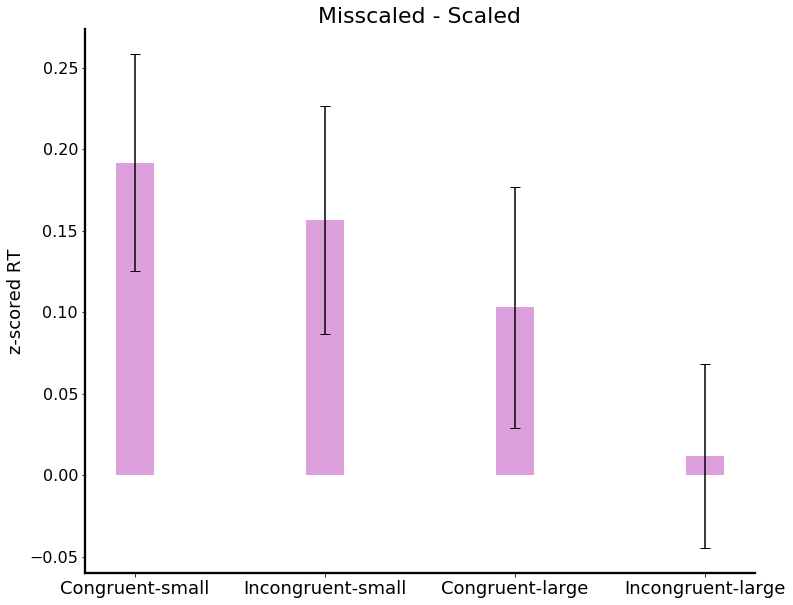

In [63]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
    
RT_diffs = [np.mean(np.array(small_RT_diffs_objSC)), np.mean(np.array(small_RT_diffs_objSIC)), np.mean(np.array(large_RT_diffs_objSC)), np.mean(np.array(large_RT_diffs_objSIC))]
RT_sem_diffs = [small_RT_sem_diffs_objSC, small_RT_sem_diffs_objSIC, large_RT_sem_diffs_objSC, large_RT_sem_diffs_objSIC]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, RT_diffs, width, color='plum', yerr=RT_sem_diffs, capsize=5)


plt.xticks(x, ['Congruent-small', 'Incongruent-small', 'Congruent-large', 'Incongruent-large'], fontsize='18')
# plt.ylim(0.80)
plt.yticks(fontsize=16) 
plt.ylabel("z-scored RT", fontsize=18)
# plt.legend(loc=1, fontsize=15, frameon=False)
plt.title('Misscaled - Scaled', fontsize=22)
plt.show()

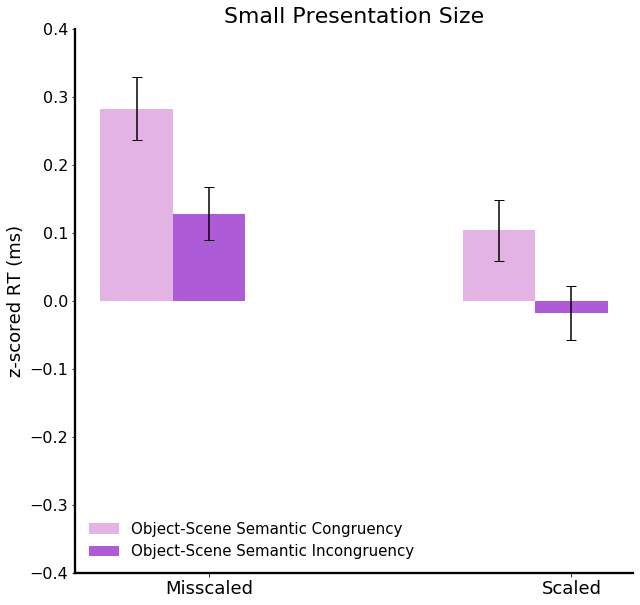

In [204]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

RT_objSemCong =   [misscaled_zi_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
RT_objSemCong_sem = [misscaled_zi_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]


RT_objSemIncong = [misscaled_zi_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
RT_objSemIncong_sem = [misscaled_zi_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]


width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.ylim(-0.4, 0.3)
plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
plt.ylabel("z-scored RT (ms)", fontsize=18)
plt.legend(loc=3, fontsize=15, frameon=False)
plt.title('Small Presentation Size', fontsize=22)
plt.show()

In [205]:
# misscaled_zo_objSemCong_CO, scaled_zo_objSemCong_CO, misscaled_zi_objSemCong_CO, scaled_zi_objSemCong_CO
# misscaled_zo_objSemIncong_CO, scaled_zo_objSemIncong_CO, misscaled_zi_objSemIncong_CO, scaled_zi_objSemIncong_CO


In [206]:
def summary_stats_byRating(data):
    '''
    returns the averages and ste for each rating (1-7)
    '''

    ratings = [1, 2, 3, 4, 5, 6, 7]

    avg_zs_rt = []
    ste_zs_rt = []
    for rat in ratings:
        r_data = data.loc[data['rating']==rat]

        avg = np.mean(np.array(r_data['Z-Scored RT']))
        avg_zs_rt.append(avg)
        ste = sem(np.array(r_data['Z-Scored RT']))
        ste_zs_rt.append(ste)

    return avg_zs_rt, ste_zs_rt    
    

In [207]:
avg_perRating_misscaled_zo_objSemCong_RT, ste_perRating_misscaled_zo_objSemCong_RT = summary_stats_byRating(misscaled_zo_objSemCong_CO)
avg_perRating_misscaled_zo_objSemIncong_RT, ste_perRating_misscaled_zo_objSemIncong_RT = summary_stats_byRating(misscaled_zo_objSemIncong_CO)

avg_perRating_misscaled_zi_objSemCong_RT, ste_perRating_misscaled_zi_objSemCong_RT = summary_stats_byRating(misscaled_zi_objSemCong_CO)
avg_perRating_misscaled_zi_objSemIncong_RT, ste_perRating_misscaled_zi_objSemIncong_RT = summary_stats_byRating(misscaled_zi_objSemIncong_CO)

avg_perRating_scaled_zo_objSemCong_RT, ste_perRating_scaled_zo_objSemCong_RT = summary_stats_byRating(scaled_zo_objSemCong_CO)
avg_perRating_scaled_zo_objSemIncong_RT, ste_perRating_scaled_zo_objSemIncong_RT = summary_stats_byRating(scaled_zo_objSemIncong_CO)

avg_perRating_scaled_zi_objSemCong_RT, ste_perRating_scaled_zi_objSemCong_RT = summary_stats_byRating(scaled_zi_objSemCong_CO)
avg_perRating_scaled_zi_objSemIncong_RT, ste_perRating_scaled_zi_objSemIncong_RT = summary_stats_byRating(scaled_zi_objSemIncong_CO)

In [208]:
# fig, ax = plt.subplots(figsize=[15,10])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2.3)
    
# x = np.arange(4)


# RT_objSemCong =   [misscaled_zo_objSemCong_RT, scaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]

# RT_objSemIncong = [misscaled_zo_objSemIncong_RT, scaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]





# width = 0.2
  
# # plot data in grouped manner of bar type
# plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
# plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
# plt.xticks(x, ['Misscaled-large', 'Scaled-large', 'Misscaled-small', 'Scaled-small'], fontsize='18')

# # Points data (you need to replace these with your pre-defined values)
# points_x = []
# points_y = []
# points_ste = []
# point_labels = []

# your_predefined_values_for_RT_objSemCong = [avg_perRating_misscaled_zo_objSemCong_RT, avg_perRating_scaled_zo_objSemCong_RT, avg_perRating_misscaled_zi_objSemCong_RT, avg_perRating_scaled_zi_objSemCong_RT]
# your_predefined_values_for_RT_objSemIncong = [avg_perRating_misscaled_zo_objSemIncong_RT, avg_perRating_scaled_zo_objSemIncong_RT, avg_perRating_misscaled_zi_objSemIncong_RT, avg_perRating_scaled_zi_objSemIncong_RT]


# ste_your_predefined_values_for_RT_objSemCong = [ste_perRating_misscaled_zo_objSemCong_RT, ste_perRating_scaled_zo_objSemCong_RT, ste_perRating_misscaled_zi_objSemCong_RT, ste_perRating_scaled_zi_objSemCong_RT]
# ste_your_predefined_values_for_RT_objSemIncong = [ste_perRating_misscaled_zo_objSemIncong_RT, ste_perRating_scaled_zo_objSemIncong_RT, ste_perRating_misscaled_zi_objSemIncong_RT, ste_perRating_scaled_zi_objSemIncong_RT]


# # Replace the following with your actual data
# for i in range(len(x)):
#     # Pre-defined values for the 7 points for each bar
#     points_x.extend([x[i] - 0.15] * 7)
#     points_y.extend(your_predefined_values_for_RT_objSemCong[i])
#     points_ste.extend(ste_your_predefined_values_for_RT_objSemCong[i])
#     point_labels.extend([str(j + 1) for j in range(7)])
    
#     points_x.extend([x[i] + 0.05] * 7)
#     points_y.extend(your_predefined_values_for_RT_objSemIncong[i])
#     points_ste.extend(ste_your_predefined_values_for_RT_objSemIncong[i])
#     point_labels.extend([str(j + 1) for j in range(7)])

# # Colors for the points (you can modify the colors as desired)
# point_colors = ['navy', 'mediumblue', 'royalblue', 'cornflowerblue', 'gold', 'darkorange', 'red']

# # Plotting the points with error bars for each bar
# for i in range(len(points_x)):
# #     plt.errorbar(points_x[i], points_y[i], yerr=points_ste[i], color=point_colors[i % 7], fmt='o', markersize=5, capsize=5, label=point_labels[i])
# #     plt.scatter(points_x[i], points_y[i], color=point_colors[i % 7], s=50, marker='o', label=point_labels[i])
#     plt.scatter(points_x[i], points_y[i], color=point_colors[i % 7], s=50, marker='o')

# plt.ylim(-0.4, 0.3)
# plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
# plt.ylabel("z-scored RT (ms)", fontsize=18)
# plt.legend(loc=0, fontsize=15, frameon=False)
# # plt.title('E5V2-RT', fontsize=22)
# plt.show()

In [209]:
print(stats.mode(list(misscaled_zo_objSemCong_CO['rating'])), np.mean(np.array(list(misscaled_zo_objSemCong_CO['rating']))))
print(stats.mode(list(misscaled_zo_objSemIncong_CO['rating'])), np.mean(np.array(list(misscaled_zo_objSemIncong_CO['rating']))))

print(stats.mode(list(scaled_zo_objSemCong_CO['rating'])), np.mean(np.array(list(scaled_zo_objSemCong_CO['rating']))))
print(stats.mode(list(scaled_zo_objSemIncong_CO['rating'])), np.mean(np.array(list(scaled_zo_objSemIncong_CO['rating']))))

print(stats.mode(list(misscaled_zi_objSemCong_CO['rating'])), np.mean(np.array(list(misscaled_zi_objSemCong_CO['rating']))))
print(stats.mode(list(misscaled_zi_objSemIncong_CO['rating'])), np.mean(np.array(list(misscaled_zi_objSemIncong_CO['rating']))))

print(stats.mode(list(scaled_zi_objSemCong_CO['rating'])), np.mean(np.array(list(scaled_zi_objSemCong_CO['rating']))))
print(stats.mode(list(scaled_zi_objSemIncong_CO['rating'])), np.mean(np.array(list(scaled_zi_objSemIncong_CO['rating']))))

ModeResult(mode=array([7]), count=array([274])) 5.8209764918625675
ModeResult(mode=array([7]), count=array([281])) 5.85251798561151
ModeResult(mode=array([4]), count=array([298])) 4.5510948905109485
ModeResult(mode=array([4]), count=array([296])) 4.670194003527337
ModeResult(mode=array([1]), count=array([185])) 2.340909090909091
ModeResult(mode=array([1]), count=array([183])) 2.3855855855855856
ModeResult(mode=array([4]), count=array([243])) 3.643510054844607
ModeResult(mode=array([4]), count=array([245])) 3.7358834244080144


ModeResult(mode=array([7]), count=array([274]))
ModeResult(mode=array([7]), count=array([281]))


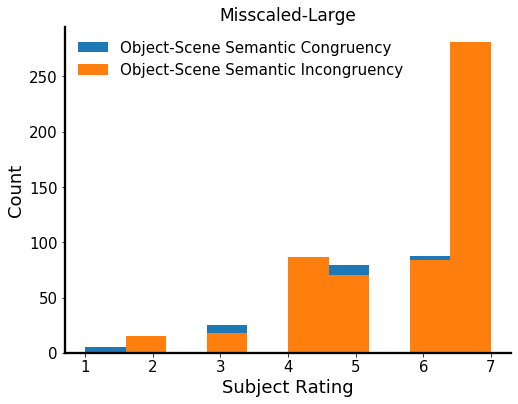

In [210]:
fig, ax = plt.subplots(figsize=[8,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = list(misscaled_zo_objSemCong_CO['rating'])
print(stats.mode(x))

y = list(misscaled_zo_objSemIncong_CO['rating'])
print(stats.mode(y))

plt.title('Misscaled-Large',fontsize=17)
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.hist(x, label='Object-Scene Semantic Congruency')
plt.hist(y, label='Object-Scene Semantic Incongruency')

plt.legend(loc=0, fontsize=15, frameon=False)

plt.show()


In [211]:
RTs_correctOnly = list(final_data_correctOnly['RT']) 

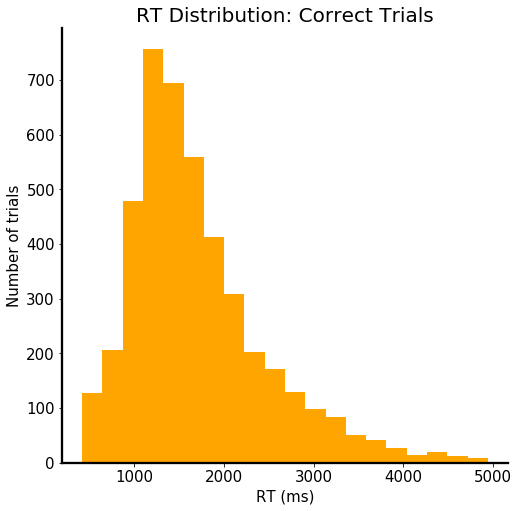

In [212]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)



for axis in ['bottom','left']:

    ax.spines[axis].set_linewidth(2.3)

plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=20)
plt.xlabel('RT (ms)', fontsize=15)
plt.ylabel('Number of trials', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Average Rating x zsRT per Object-Scene Pair

In [179]:
misscaled_zi_objSemCong_CO.columns

Index(['subjID', 'experimentName', 'versionName', 'sequenceName',
       'Z-Scored RT', 'windowWidth', 'windowHeight', 'screenWidth',
       'screenHeight', 'startDate', 'startTime', 'pracTries', 'trialNum',
       'scene', 'size_name', 'image_name', 'object', 'side', 'objectCategory',
       'objSceneSemCong', 'scale', 'image', 'presentationSize', 'keyPress',
       'accuracy', 'RT', 'ratingTrialNum', 'rating', 'thisRatingTrialFile',
       'experimentTime', 'totalTime', 'age', 'gender'],
      dtype='object')

In [180]:
# data: misscaled_zi_CO, scaled_zi_CO
# all RTs for object-scene pairs

RT_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_ms_sm.keys():
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['Z-Scored RT'])

RT_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_s_sm.keys():
        RT_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['Z-Scored RT'])

In [181]:
# data: misscaled_zi_CO, scaled_zi_CO
# all ratings for object-scene pairs

rating_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_ms_sm.keys():
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['rating'])

rating_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_s_sm.keys():
        rating_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['rating'])

In [182]:
combined_dict_ms_sm = {key: [RT_by_obj_scene_pair_ms_sm[key], rating_by_obj_scene_pair_ms_sm[key]] for key in RT_by_obj_scene_pair_ms_sm}

combined_dict_s_sm = {key: [RT_by_obj_scene_pair_s_sm[key], rating_by_obj_scene_pair_s_sm[key]] for key in RT_by_obj_scene_pair_s_sm}


In [183]:
avgs_ms_sm = {}

for key in combined_dict_ms_sm:
    avg_rt = np.mean(np.array(combined_dict_ms_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_ms_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_ms_sm[key][1]))
    
    avgs_ms_sm[key] = [avg_rt, ste_rt, avg_rating]

avgs_s_sm = {}

for key in combined_dict_s_sm:
    avg_rt = np.mean(np.array(combined_dict_s_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_s_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_s_sm[key][1]))
    
    avgs_s_sm[key] = [avg_rt, ste_rt, avg_rating]

In [184]:
len(avgs_ms_sm.keys())


72

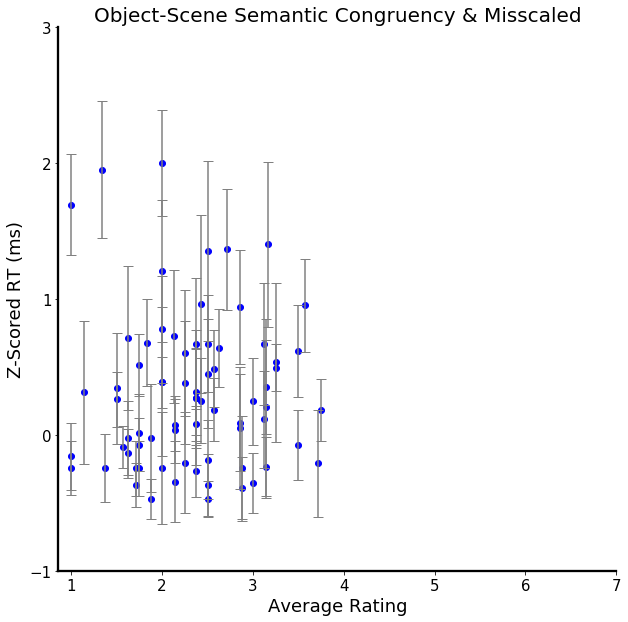

In [185]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Object-Scene Semantic Congruency & Misscaled', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

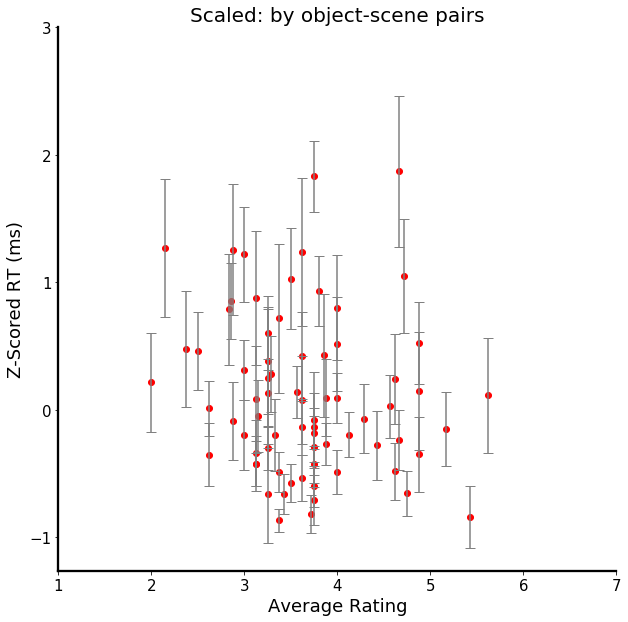

In [186]:
data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='red', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Scaled: by object-scene pairs', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

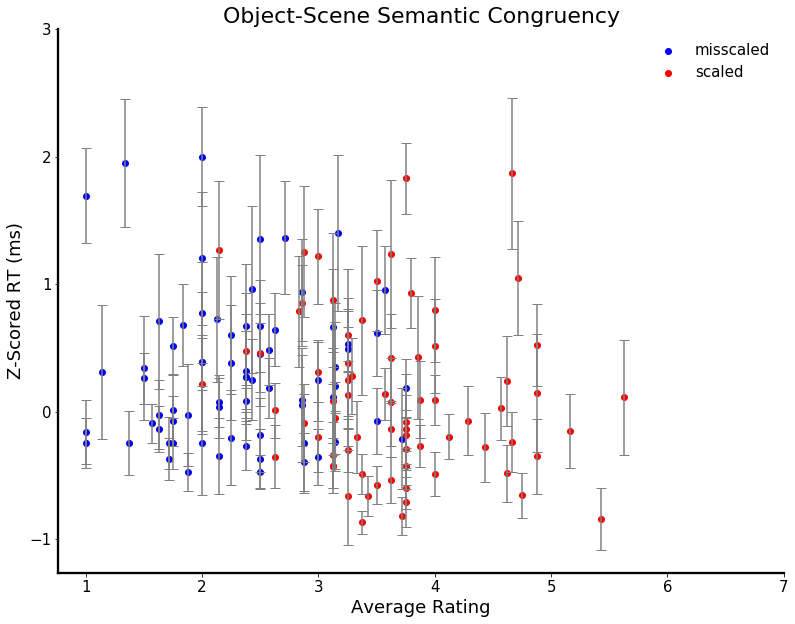

In [187]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[13,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='misscaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

plt.scatter(x, y, marker='o', color='red', label='scaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
plt.legend(loc=0, fontsize=15, frameon=False)

plt.title('Object-Scene Semantic Congruency', fontsize=22)


# Show plot
plt.show()

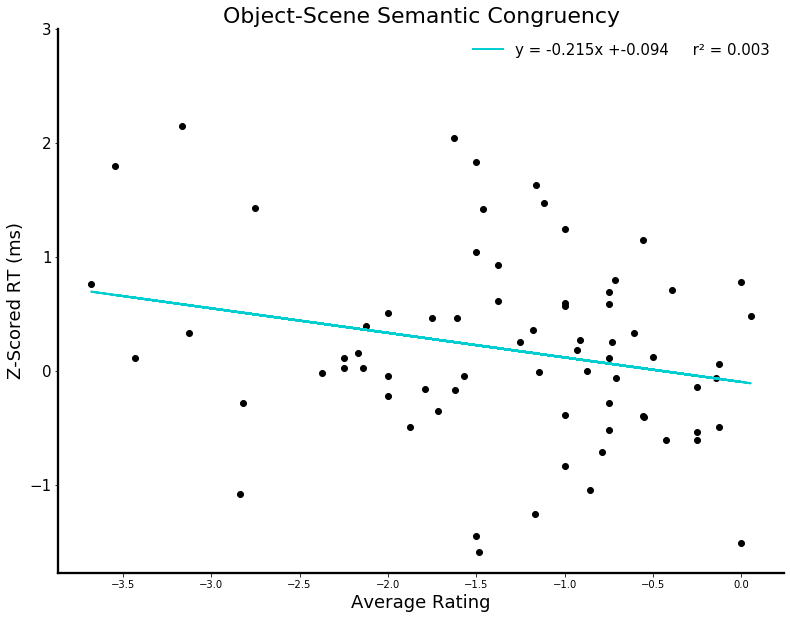

(-0.11762212218784775, 0.3251103988564658)


In [188]:
import scipy 

# Extract keys and values
ms_keys = list(avgs_ms_sm.keys())
ms_values = list(avgs_ms_sm.values())

# Extract x (last value) and y (first value) coordinates
ms_x = np.array([item[2] for item in ms_values])
ms_y = np.array([item[0] for item in ms_values])

# Extract standard error for error bars
ms_error = [item[1] for item in ms_values]


# Extract keys and values
s_keys = list(avgs_s_sm.keys())
s_values = list(avgs_s_sm.values())

# Extract x (last value) and y (first value) coordinates
s_x = np.array([item[2] for item in s_values])
s_y = np.array([item[0] for item in s_values])

# Extract standard error for error bars
s_error = [item[1] for item in s_values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[13,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# plt.scatter(ms_x, ms_y-s_y, marker='o', color='black', label='misscaled-scaled')

# Add error bars
# plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

#run regression
X = np.array(ms_x-s_x).reshape(-1,1)
y = ms_y-s_y


reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 1);
plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)), linewidth=2)


# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)

# plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
plt.legend(loc=0, fontsize=15, frameon=False)

plt.title('Object-Scene Semantic Congruency', fontsize=22)

# Show plot
plt.show()

print(scipy.stats.pearsonr(ms_x, ms_y-s_y))

In [189]:
misscaled_zi_objSemCong_CO.columns

Index(['subjID', 'experimentName', 'versionName', 'sequenceName',
       'Z-Scored RT', 'windowWidth', 'windowHeight', 'screenWidth',
       'screenHeight', 'startDate', 'startTime', 'pracTries', 'trialNum',
       'scene', 'size_name', 'image_name', 'object', 'side', 'objectCategory',
       'objSceneSemCong', 'scale', 'image', 'presentationSize', 'keyPress',
       'accuracy', 'RT', 'ratingTrialNum', 'rating', 'thisRatingTrialFile',
       'experimentTime', 'totalTime', 'age', 'gender'],
      dtype='object')

In [190]:
# data: misscaled_zi_CO, scaled_zi_CO
# all RTs for object-scene pairs

RT_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_ms_sm.keys():
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['Z-Scored RT'])

RT_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_s_sm.keys():
        RT_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['Z-Scored RT'])

In [191]:
# data: misscaled_zi_CO, scaled_zi_CO
# all ratings for object-scene pairs

rating_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_ms_sm.keys():
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['rating'])

rating_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_s_sm.keys():
        rating_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['rating'])

In [192]:
combined_dict_ms_sm = {key: [RT_by_obj_scene_pair_ms_sm[key], rating_by_obj_scene_pair_ms_sm[key]] for key in RT_by_obj_scene_pair_ms_sm}

combined_dict_s_sm = {key: [RT_by_obj_scene_pair_s_sm[key], rating_by_obj_scene_pair_s_sm[key]] for key in RT_by_obj_scene_pair_s_sm}


In [193]:
avgs_ms_sm = {}

for key in combined_dict_ms_sm:
    avg_rt = np.mean(np.array(combined_dict_ms_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_ms_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_ms_sm[key][1]))
    
    avgs_ms_sm[key] = [avg_rt, ste_rt, avg_rating]

avgs_s_sm = {}

for key in combined_dict_s_sm:
    avg_rt = np.mean(np.array(combined_dict_s_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_s_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_s_sm[key][1]))
    
    avgs_s_sm[key] = [avg_rt, ste_rt, avg_rating]

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [194]:
len(avgs_ms_sm.keys())


72

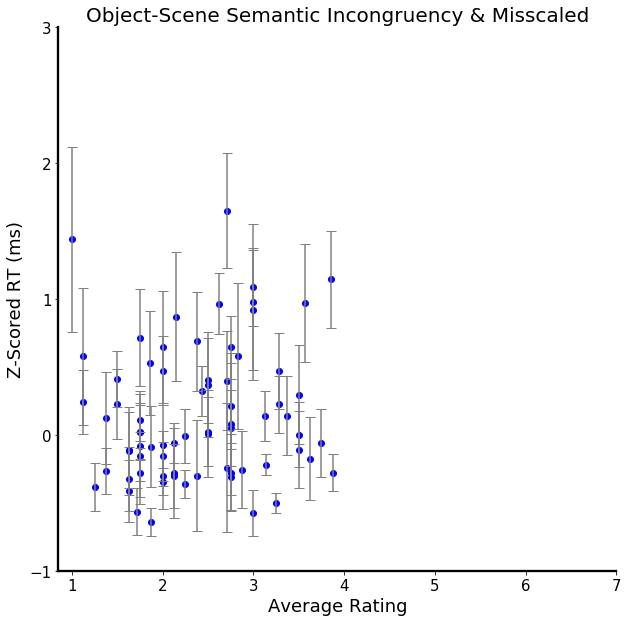

In [195]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Object-Scene Semantic Incongruency & Misscaled', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

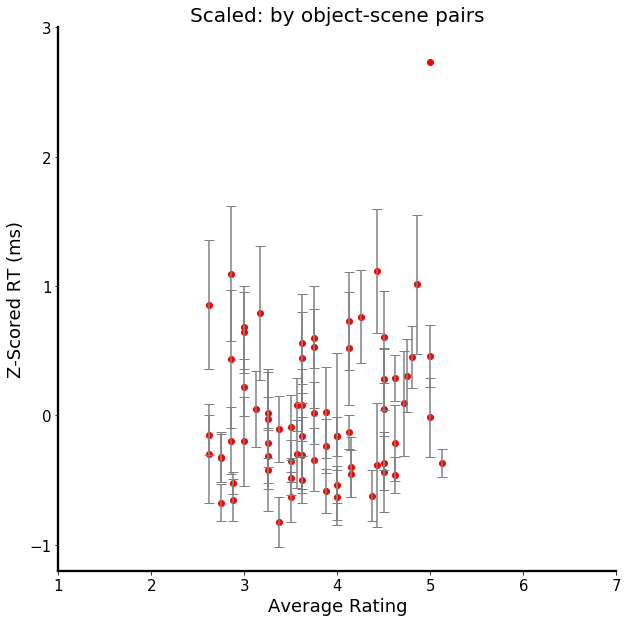

In [196]:
data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='red', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Scaled: by object-scene pairs', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

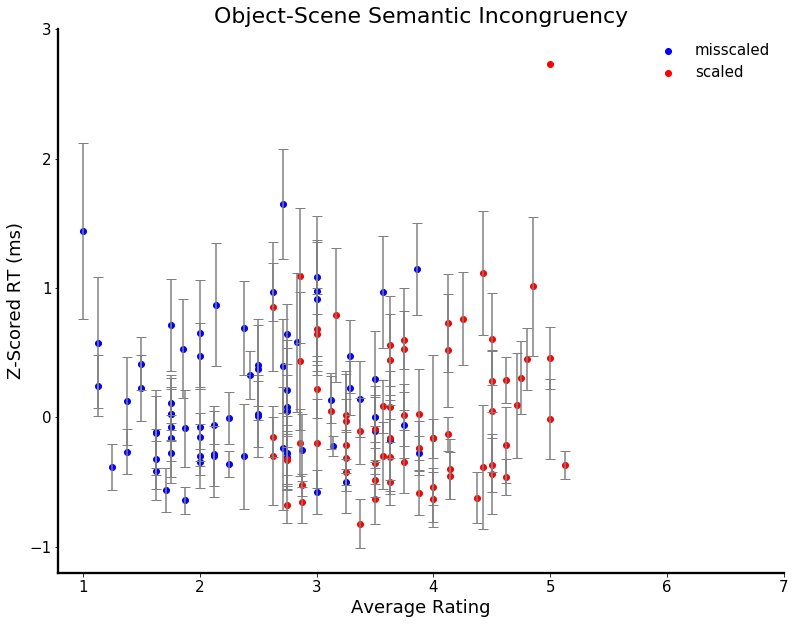

In [197]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[13,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='misscaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

plt.scatter(x, y, marker='o', color='red', label='scaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
plt.legend(loc=0, fontsize=15, frameon=False)

plt.title('Object-Scene Semantic Incongruency', fontsize=22)

# Show plot
plt.show()

In [198]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

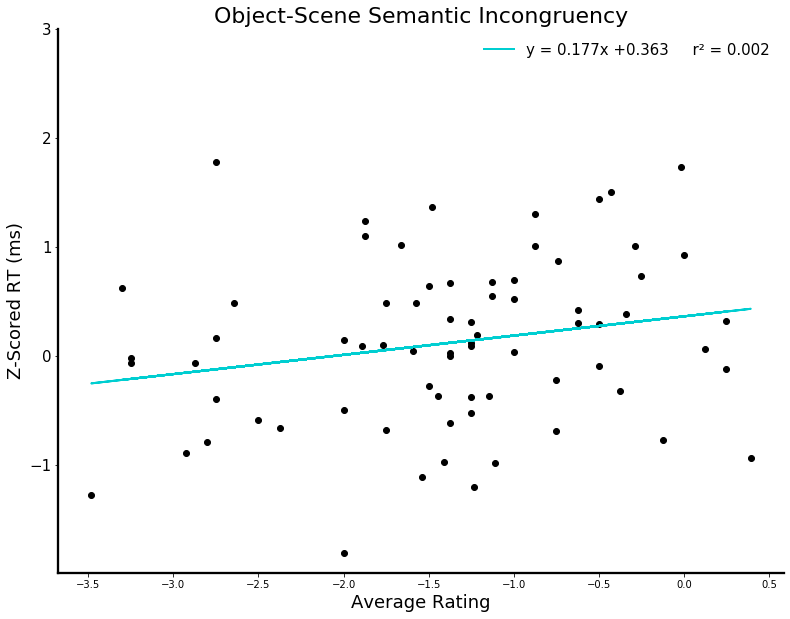

(0.21528628745594852, 0.069346714539796)


In [200]:
from sklearn.linear_model import LinearRegression

# Extract keys and values
ms_keys = list(avgs_ms_sm.keys())
ms_values = list(avgs_ms_sm.values())

# Extract x (last value) and y (first value) coordinates
ms_x = np.array([item[2] for item in ms_values])
ms_y = np.array([item[0] for item in ms_values])

# Extract standard error for error bars
ms_error = [item[1] for item in ms_values]


# Extract keys and values
s_keys = list(avgs_s_sm.keys())
s_values = list(avgs_s_sm.values())

# Extract x (last value) and y (first value) coordinates
s_x = np.array([item[2] for item in s_values])
s_y = np.array([item[0] for item in s_values])

# Extract standard error for error bars
s_error = [item[1] for item in s_values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[13,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# plt.scatter(ms_x, ms_y-s_y, marker='o', color='black', label='misscaled-scaled')

# Add error bars
# plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

#run regression
X = np.array(ms_x-s_x).reshape(-1,1)
y = ms_y-s_y


reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 1);
plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)), linewidth=2)


# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)

# plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
plt.legend(loc=0, fontsize=15, frameon=False)

plt.title('Object-Scene Semantic Incongruency', fontsize=22)

# Show plot
plt.show()
print(scipy.stats.pearsonr(ms_x-s_x, ms_y-s_y))


## Inverse Efficiency Score 

RT/acc

In [143]:
final_data.columns

Index(['subjID', 'experimentName', 'versionName', 'sequenceName',
       'Z-Scored RT', 'windowWidth', 'windowHeight', 'screenWidth',
       'screenHeight', 'startDate', 'startTime', 'pracTries', 'trialNum',
       'scene', 'IES', 'size_name', 'image_name', 'object', 'side',
       'objectCategory', 'objSceneSemCong', 'scale', 'image',
       'presentationSize', 'keyPress', 'accuracy', 'RT', 'ratingTrialNum',
       'rating', 'thisRatingTrialFile', 'experimentTime', 'totalTime', 'age',
       'gender'],
      dtype='object')

In [288]:
np.mean(np.array(RTs_correctOnly)), np.mean(np.array(final_data['RT']))

(1702.138769021122, 1709.1326283322317)

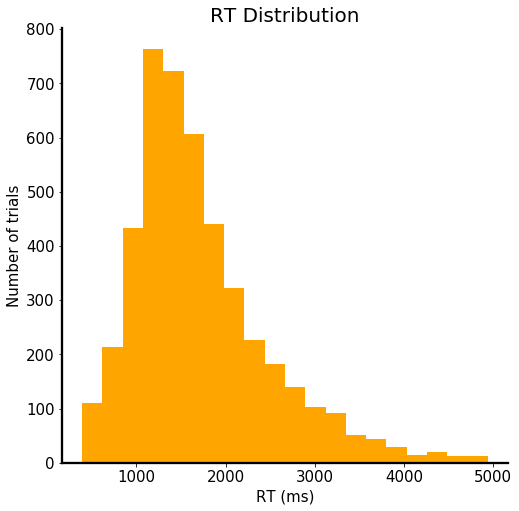

In [285]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)



for axis in ['bottom','left']:

    ax.spines[axis].set_linewidth(2.3)

plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=20)
plt.xlabel('RT (ms)', fontsize=15)
plt.ylabel('Number of trials', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [177]:
np.min(np.array(final_data['IES']))

-198.18896417185417

In [292]:
final_data.columns

Index(['subjID', 'experimentName', 'versionName', 'sequenceName',
       'Z-Scored RT', 'windowWidth', 'windowHeight', 'screenWidth',
       'screenHeight', 'startDate', 'startTime', 'pracTries', 'trialNum',
       'scene', 'size_name', 'image_name', 'object', 'side', 'objectCategory',
       'objSceneSemCong', 'scale', 'image', 'presentationSize', 'keyPress',
       'accuracy', 'RT', 'ratingTrialNum', 'rating', 'thisRatingTrialFile',
       'experimentTime', 'totalTime', 'age', 'gender'],
      dtype='object')

In [75]:

zo_df_NCO = final_data.loc[final_data['presentationSize']=='large']
zi_df_NCO = final_data.loc[final_data['presentationSize']=='small']

zo_NCO_RT = np.mean(np.array(zo_df_NCO['Z-Scored RT']))
zi_NCO_RT = np.mean(np.array(zi_df_NCO['Z-Scored RT']))

misscaled_zo_NCO = zo_df_NCO.loc[zo_df_NCO['scale'] =='misscaled'] 
misscaled_zi_NCO = zi_df_NCO.loc[zi_df_NCO['scale'] =='misscaled']
misscaled_NCO = misscaled_zo_NCO.append(misscaled_zi_NCO)

scaled_zo_NCO = zo_df_NCO.loc[zo_df_NCO['scale'] =='scaled'] 
scaled_zi_NCO = zi_df_NCO.loc[zi_df_NCO['scale'] =='scaled']
scaled_NCO = scaled_zo_NCO.append(scaled_zi_NCO)


# misscaled
misscaled_zo_objSemCong_NCO = misscaled_zo_NCO.loc[misscaled_zo_NCO["objSceneSemCong"]==1]
misscaled_zo_objSemIncong_NCO = misscaled_zo_NCO.loc[misscaled_zo_NCO["objSceneSemCong"]==0]

misscaled_zo_objSemCong_NCO_RT = np.mean(np.array(misscaled_zo_objSemCong_NCO['Z-Scored RT']))
misscaled_zo_objSemIncong_NCO_RT = np.mean(np.array(misscaled_zo_objSemIncong_NCO['Z-Scored RT']))

misscaled_zo_objSemCong_NCO_RT_sem = sem(np.array(misscaled_zo_objSemCong_NCO['Z-Scored RT']))
misscaled_zo_objSemIncong_NCO_RT_sem = sem(np.array(misscaled_zo_objSemIncong_NCO['Z-Scored RT']))


misscaled_zi_objSemCong_NCO = misscaled_zi_NCO.loc[misscaled_zi_NCO["objSceneSemCong"]==1]
misscaled_zi_objSemIncong_NCO = misscaled_zi_NCO.loc[misscaled_zi_NCO["objSceneSemCong"]==0]

misscaled_zi_objSemCong_NCO_RT = np.mean(np.array(misscaled_zi_objSemCong_NCO['Z-Scored RT']))
misscaled_zi_objSemIncong_NCO_RT = np.mean(np.array(misscaled_zi_objSemIncong_NCO['Z-Scored RT']))

misscaled_zi_objSemCong_NCO_RT_sem = sem(np.array(misscaled_zi_objSemCong_NCO['Z-Scored RT']))
misscaled_zi_objSemIncong_NCO_RT_sem = sem(np.array(misscaled_zi_objSemIncong_NCO['Z-Scored RT']))


# scaled
scaled_zo_objSemCong_NCO = scaled_zo_NCO.loc[scaled_zo_NCO["objSceneSemCong"]==1]
scaled_zo_objSemIncong_NCO = scaled_zo_NCO.loc[scaled_zo_NCO["objSceneSemCong"]==0]

scaled_zo_objSemCong_NCO_RT = np.mean(np.array(scaled_zo_objSemCong_NCO['Z-Scored RT']))
scaled_zo_objSemIncong_NCO_RT = np.mean(np.array(scaled_zo_objSemIncong_NCO['Z-Scored RT']))

scaled_zo_objSemCong_NCO_RT_sem = sem(np.array(scaled_zo_objSemCong_NCO['Z-Scored RT']))
scaled_zo_objSemIncong_NCO_RT_sem = sem(np.array(scaled_zo_objSemIncong_NCO['Z-Scored RT']))


scaled_zi_objSemCong_NCO = scaled_zi_NCO.loc[scaled_zi_NCO["objSceneSemCong"]==1]
scaled_zi_objSemIncong_NCO = scaled_zi_NCO.loc[scaled_zi_NCO["objSceneSemCong"]==0]

scaled_zi_objSemCong_NCO_RT = np.mean(np.array(scaled_zi_objSemCong_NCO['Z-Scored RT']))
scaled_zi_objSemIncong_NCO_RT = np.mean(np.array(scaled_zi_objSemIncong_NCO['Z-Scored RT']))

scaled_zi_objSemCong_NCO_RT_sem = sem(np.array(scaled_zi_objSemCong_NCO['Z-Scored RT']))
scaled_zi_objSemIncong_NCO_RT_sem = sem(np.array(scaled_zi_objSemIncong_NCO['Z-Scored RT']))

In [76]:
misscaled_zo_objSemCong_acc

0.9667832167832168

In [77]:
ies_data = {'misscaled_presentationSizeLarge_objSceneSemCong': misscaled_zo_objSemCong_NCO_RT/misscaled_zo_objSemCong_acc,
            'misscaled_presentationSizeSmall_objSceneSemCong': misscaled_zi_objSemCong_NCO_RT/misscaled_zi_objSemCong_acc,
            'scaled_presentationSizeLarge_objSceneSemCong': scaled_zo_objSemCong_NCO_RT/scaled_zo_objSemCong_acc,
            'scaled_presentationSizeSmall_objSceneSemCong': scaled_zi_objSemCong_NCO_RT/scaled_zi_objSemCong_acc,
            'misscaled_presentationSizeLarge_objSceneSemIncong': misscaled_zo_objSemIncong_NCO_RT/misscaled_zo_objSemIncong_acc,
            'misscaled_presentationSizeSmall_objSceneSemIncong': misscaled_zi_objSemIncong_NCO_RT/misscaled_zi_objSemIncong_acc,
            'scaled_presentationSizeLarge_objSceneSemIncong': scaled_zo_objSemIncong_NCO_RT/scaled_zo_objSemIncong_acc,
            'scaled_presentationSizeSmall_objSceneSemIncong': scaled_zi_objSemIncong_NCO_RT/scaled_zi_objSemIncong_acc,
        'age': ['5', '10', '7', '6']} 
ies_df = pd.DataFrame.from_dict(ies_data)

In [78]:
misscaled_zo_objSemCong_NCO_RT, misscaled_zo_objSemCong_RT

(-0.08581463715074915, -0.08751614463718976)

In [79]:
# (RT_ste+ mean RT)/( mean acc +acc_ste)

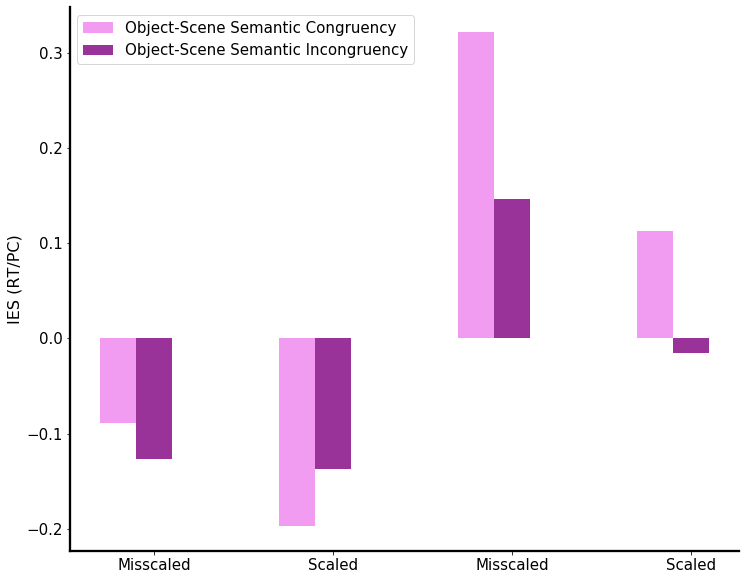

In [297]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

IES_objSemCong =   [misscaled_zo_objSemCong_NCO_RT/misscaled_zo_objSemCong_acc, scaled_zo_objSemCong_NCO_RT/scaled_zo_objSemCong_acc, misscaled_zi_objSemCong_NCO_RT/misscaled_zi_objSemCong_acc, scaled_zi_objSemCong_NCO_RT/scaled_zi_objSemCong_acc]

IES_objSemIncong = [misscaled_zo_objSemIncong_NCO_RT/misscaled_zo_objSemIncong_acc, scaled_zo_objSemIncong_NCO_RT/scaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_NCO_RT/misscaled_zi_objSemIncong_acc,scaled_zi_objSemIncong_NCO_RT/scaled_zi_objSemIncong_acc]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_objSemCong, width, color='violet', label='Object-Scene Semantic Congruency', capsize=5, alpha=0.8)
plt.bar(x, IES_objSemIncong, width, color='purple', label='Object-Scene Semantic Incongruency', capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled', 'Scaled', 'Misscaled',  'Scaled'], fontsize='15')
plt.yticks(fontsize=15) 
# plt.ylim(1200)
plt.ylabel("IES (RT/PC)", fontsize=16)
plt.legend(loc=2, fontsize=15)
plt.show()

In [ ]:
# (RT_ste+ mean RT)/( mean acc +acc_ste)

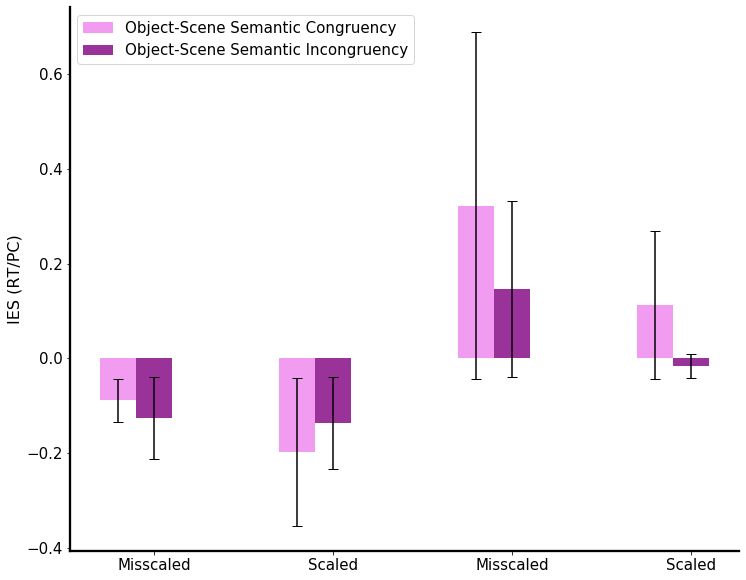

In [81]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

IES_objSemCong =   [misscaled_zo_objSemCong_NCO_RT/misscaled_zo_objSemCong_acc, scaled_zo_objSemCong_NCO_RT/scaled_zo_objSemCong_acc, misscaled_zi_objSemCong_NCO_RT/misscaled_zi_objSemCong_acc, scaled_zi_objSemCong_NCO_RT/scaled_zi_objSemCong_acc]
IES_objSemCong_sem = [(misscaled_zo_objSemCong_NCO_RT+misscaled_zo_objSemCong_NCO_RT_sem)/(misscaled_zo_objSemCong_acc+misscaled_zo_objSemCong_sem), (scaled_zo_objSemCong_NCO_RT+scaled_zo_objSemCong_NCO_RT_sem)/(scaled_zo_objSemCong_acc+scaled_zo_objSemCong_sem), (misscaled_zi_objSemCong_NCO_RT+misscaled_zi_objSemCong_NCO_RT_sem)/(misscaled_zi_objSemCong_acc+misscaled_zi_objSemCong_sem),  (scaled_zi_objSemCong_NCO_RT+scaled_zi_objSemCong_NCO_RT_sem)/(scaled_zi_objSemCong_acc+scaled_zi_objSemCong_sem)]

IES_objSemIncong = [misscaled_zo_objSemIncong_NCO_RT/misscaled_zo_objSemIncong_acc, scaled_zo_objSemIncong_NCO_RT/scaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_NCO_RT/misscaled_zi_objSemIncong_acc,  scaled_zi_objSemIncong_NCO_RT/scaled_zi_objSemIncong_acc]
IES_objSemIncong_sem = [(misscaled_zo_objSemIncong_NCO_RT+misscaled_zo_objSemIncong_NCO_RT_sem)/(misscaled_zo_objSemIncong_acc+misscaled_zo_objSemIncong_sem), (scaled_zo_objSemIncong_NCO_RT+scaled_zo_objSemIncong_NCO_RT_sem)/(scaled_zo_objSemIncong_acc+scaled_zo_objSemIncong_sem), (misscaled_zi_objSemIncong_NCO_RT+ misscaled_zi_objSemIncong_NCO_RT_sem)/(misscaled_zi_objSemIncong_acc+misscaled_zi_objSemIncong_sem),  (scaled_zi_objSemIncong_NCO_RT+scaled_zi_objSemIncong_NCO_RT_sem)/(scaled_zi_objSemIncong_acc+scaled_zi_objSemIncong_sem)]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_objSemCong, width, color='violet', label='Object-Scene Semantic Congruency', yerr=IES_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, IES_objSemIncong, width, color='purple', label='Object-Scene Semantic Incongruency', yerr=IES_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled', 'Scaled', 'Misscaled',  'Scaled'], fontsize='15')
plt.yticks(fontsize=15) 
# plt.ylim(700)
plt.ylabel("IES (RT/PC)", fontsize=16)
plt.legend(loc=0, fontsize=15)
plt.show()

In [118]:
ies_df.to_csv('IES_e5v2Final.csv', index=False)

# Analyze Data by Mis-scaling Rating

In [236]:
data_1 = final_data.loc[final_data['rating'] == 1]
data_2 = final_data.loc[final_data['rating'] == 2]
data_3 = final_data.loc[final_data['rating'] == 3]
data_4 = final_data.loc[final_data['rating'] == 4]




In [237]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])

(244, 167, 166, 697)

In [238]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])


(244, 167, 166, 697)

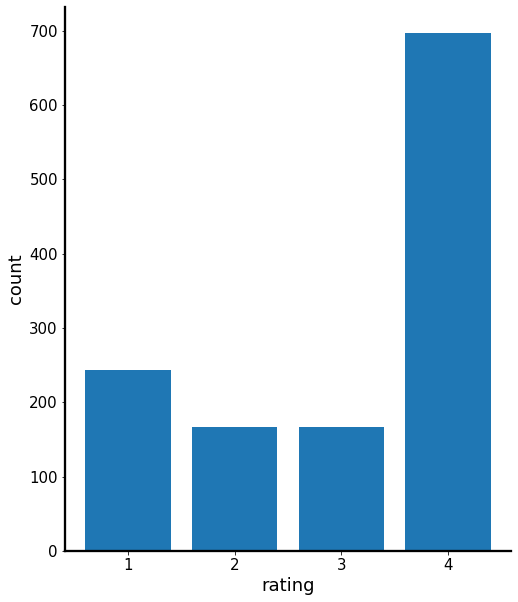

In [239]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)
    
plt.bar(['1', '2', '3', '4'], [len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])
])
plt.show()

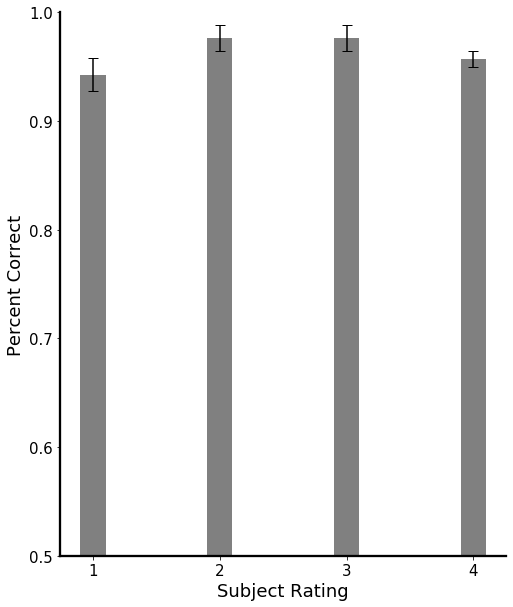

In [240]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_ =   [np.sum(np.array(data_1['accuracy']))/len(np.array(data_1['accuracy'])), np.sum(np.array(data_2['accuracy']))/len(np.array(data_2['accuracy'])), np.sum(np.array(data_3['accuracy']))/len(np.array(data_3['accuracy'])), np.sum(np.array(data_4['accuracy']))/len(np.array(data_4['accuracy']))]
yerr_ =  [np.std(np.array(data_1['accuracy']))/np.sqrt(len(np.array(data_1['accuracy']))), np.std(np.array(data_2['accuracy']))/np.sqrt(len(np.array(data_2['accuracy']))), np.std(np.array(data_3['accuracy']))/np.sqrt(len(np.array(data_3['accuracy']))), np.std(np.array(data_4['accuracy']))/np.sqrt(len(np.array(data_4['accuracy'])))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, Acc_, width, color='gray', yerr=yerr_, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.50, 1)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

In [241]:
# Accuracy

data_1_acc = np.sum(np.array(data_1['accuracy']))/len(np.array(data_1['accuracy']))

data_1_sem = np.std(np.array(data_1['accuracy']))/np.sqrt(len(np.array(data_1['accuracy'])))

print(len(np.array(data_1['accuracy'])))


data_2_acc = np.sum(np.array(data_2['accuracy']))/len(np.array(data_2['accuracy']))

data_2_sem = np.std(np.array(data_2['accuracy']))/np.sqrt(len(np.array(data_2['accuracy'])))

print(len(np.array(data_2['accuracy'])))


data_3_acc = np.sum(np.array(data_3['accuracy']))/len(np.array(data_3['accuracy']))

data_3_sem = np.std(np.array(data_3['accuracy']))/np.sqrt(len(np.array(data_3['accuracy'])))

print(len(np.array(data_3['accuracy'])))

data_4_acc = np.sum(np.array(data_4['accuracy']))/len(np.array(data_4['accuracy']))

data_4_sem = np.std(np.array(data_4['accuracy']))/np.sqrt(len(np.array(data_4['accuracy'])))

print(len(np.array(data_4['accuracy'])))


244
167
166
697


In [242]:
data_1_objectScene1SemanticCongruency0 = data_1.loc[data_1['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1 = data_1.loc[data_1['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0 = data_2.loc[data_2['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1 = data_2.loc[data_2['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0 = data_3.loc[data_3['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1 = data_3.loc[data_3['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0 = data_4.loc[data_4['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1 = data_4.loc[data_4['objSceneSemCong'] == 1]


In [243]:
# Accuracy

data_1_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))
data_1_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))

data_1_objectScene1SemanticCongruency0_sem = np.std(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))
data_1_objectScene1SemanticCongruency1_sem = np.std(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))

data_2_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))
data_2_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))

data_2_objectScene1SemanticCongruency0_sem = np.std(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))
data_2_objectScene1SemanticCongruency1_sem = np.std(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))

data_3_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))
data_3_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))

data_3_objectScene1SemanticCongruency0_sem = np.std(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))
data_3_objectScene1SemanticCongruency1_sem = np.std(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))

data_4_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))
data_4_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))

data_4_objectScene1SemanticCongruency0_sem = np.std(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))
data_4_objectScene1SemanticCongruency1_sem = np.std(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))


234
176
174
712


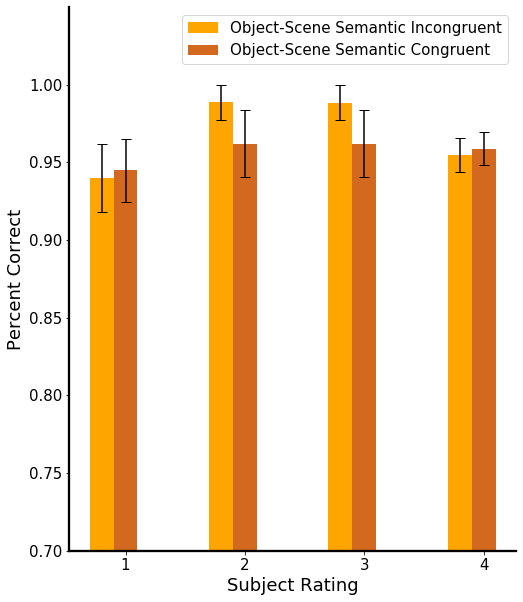

In [244]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_0 =   [data_1_objectScene1SemanticCongruency0_acc, data_2_objectScene1SemanticCongruency0_acc, data_3_objectScene1SemanticCongruency0_acc, data_4_objectScene1SemanticCongruency0_acc]
yerr_0 =  [data_1_objectScene1SemanticCongruency0_sem, data_2_objectScene1SemanticCongruency0_sem, data_3_objectScene1SemanticCongruency0_sem, data_4_objectScene1SemanticCongruency0_sem]

Acc_1 =   [data_1_objectScene1SemanticCongruency1_acc, data_2_objectScene1SemanticCongruency1_acc, data_3_objectScene1SemanticCongruency1_acc, data_4_objectScene1SemanticCongruency1_acc]
yerr_1 =  [data_1_objectScene1SemanticCongruency1_sem, data_2_objectScene1SemanticCongruency1_sem, data_3_objectScene1SemanticCongruency1_sem, data_4_objectScene1SemanticCongruency1_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_0, width, color='orange', label='Object-Scene Semantic Incongruent', yerr=yerr_0, capsize=5)
plt.bar(x, Acc_1, width, color='chocolate', label='Object-Scene Semantic Congruent', yerr=yerr_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.70)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [245]:
data_1_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 1]
data_2_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 2]
data_3_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 3]
data_4_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 4]





In [246]:
# RT 
data_1_RT = np.mean(np.array(data_1_CO['RT']))

data_1_RT_sem = sem(np.array(data_1_CO['RT']))


data_2_RT = np.mean(np.array(data_2_CO['RT']))

data_2_RT_sem = sem(np.array(data_2_CO['RT']))


data_3_RT = np.mean(np.array(data_3_CO['RT']))

data_3_RT_sem = sem(np.array(data_3_CO['RT']))


data_4_RT = np.mean(np.array(data_4_CO['RT']))

data_4_RT_sem = sem(np.array(data_4_CO['RT']))



In [247]:
len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy'])

(230, 163, 162, 667)

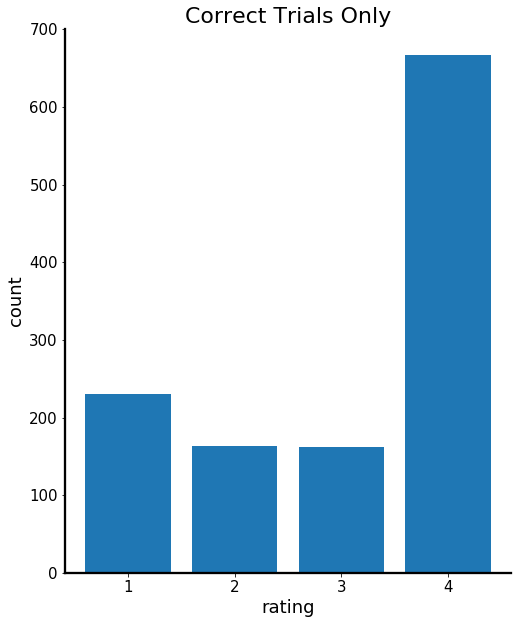

In [248]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)

plt.title('Correct Trials Only', fontsize=22)
    
plt.bar(['1', '2', '3', '4'], [len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy'])])

plt.show()

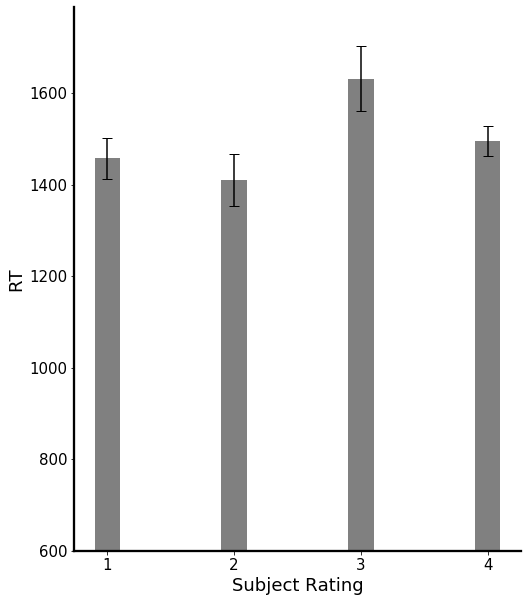

In [249]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_ = [np.mean(np.array(data_1_CO['RT'])), np.mean(np.array(data_2_CO['RT'])), np.mean(np.array(data_3_CO['RT'])), np.mean(np.array(data_4_CO['RT']))]
yerr_RT = [sem(np.array(data_1_CO['RT'])), sem(np.array(data_2_CO['RT'])), sem(np.array(data_3_CO['RT'])), sem(np.array(data_4_CO['RT']))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, RT_, width, color='gray', yerr=yerr_RT, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(600)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

In [250]:
data_1_objectScene1SemanticCongruency0_CO = data_1_CO.loc[data_1_CO['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1_CO = data_1_CO.loc[data_1_CO['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0_CO = data_2_CO.loc[data_2_CO['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1_CO = data_2_CO.loc[data_2_CO['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0_CO = data_3_CO.loc[data_3_CO['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1_CO = data_3_CO.loc[data_3_CO['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0_CO = data_4_CO.loc[data_4_CO['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1_CO = data_4_CO.loc[data_4_CO['objSceneSemCong'] == 1]


In [251]:
data_1_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))

data_1_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))


data_2_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))

data_2_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))


data_3_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))

data_3_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT_sem =sem(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))


data_4_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))

data_4_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))




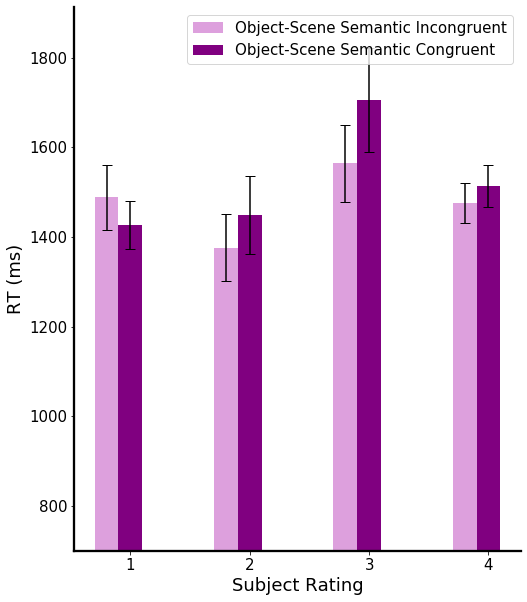

In [252]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_0 =   [data_1_objectScene1SemanticCongruency0_CO_RT, data_2_objectScene1SemanticCongruency0_CO_RT, data_3_objectScene1SemanticCongruency0_CO_RT, data_4_objectScene1SemanticCongruency0_CO_RT]
yerr_RT_0 =  [data_1_objectScene1SemanticCongruency0_CO_RT_sem, data_2_objectScene1SemanticCongruency0_CO_RT_sem, data_3_objectScene1SemanticCongruency0_CO_RT_sem, data_4_objectScene1SemanticCongruency0_CO_RT_sem]

RT_1 =   [data_1_objectScene1SemanticCongruency1_CO_RT, data_2_objectScene1SemanticCongruency1_CO_RT, data_3_objectScene1SemanticCongruency1_CO_RT, data_4_objectScene1SemanticCongruency1_CO_RT]
yerr_RT_1 =  [data_1_objectScene1SemanticCongruency1_CO_RT_sem, data_2_objectScene1SemanticCongruency1_CO_RT_sem, data_3_objectScene1SemanticCongruency1_CO_RT_sem, data_4_objectScene1SemanticCongruency1_CO_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_0, width, color='plum', label='Object-Scene Semantic Incongruent', yerr=yerr_RT_0, capsize=5)
plt.bar(x, RT_1, width, color='purple', label='Object-Scene Semantic Congruent', yerr=yerr_RT_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(700)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT (ms)", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

## Demographics + Other

### Screen Size

In [4]:
screenWidths = np.array(final_data['screenWidth'])
screenHeights = np.array(final_data['screenHeight'])

np.mean(screenWidths), np.std(screenWidths)

(1407.088565763384, 177.03319653681868)

### Time Taken

In [5]:
np.mean((np.array(final_data['totalTime'])//1000)/60), np.std((np.array(final_data['totalTime'])//1000)/60)

(8.740544907101416, 4.358437222015022)

### Age

In [7]:
ages = []
for subj in final_data.subjID.unique():
    subj_age = final_data.loc[final_data['subjID']==subj].age.unique()[0]
    if subj_age < 18:
        print(subj_age)
        pass
    else:
        if subj_age > 1900:
            print(subj_age)
            subj_age = 2023 - subj_age
            
    ages.append(subj_age)

np.mean(np.array(ages)), np.std(np.array(ages))

1998.0
1992.0
1990.0
1998.0
1998.0
1998.0
1964.0
1988.0
1998.0
1993.0
1998.0
1998.0
1998.0
1994.0
1993.0
1998.0
1964.0
1991.0


(34.25, 9.869460471575941)

In [18]:
np.min(np.array(ages)), np.max(np.array(ages))

(21.0, 62.0)

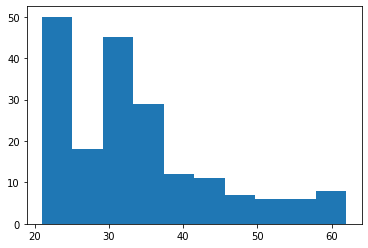

In [9]:
plt.hist(ages)
plt.show()

### Gender

In [11]:
final_data.gender.unique()

array(['Man', 'Woman'], dtype=object)

In [15]:
gender_dict_count = {}
for response in final_data.gender.unique():
    gender_dict_count[response] = 0

gender_dict_count

{'Man': 0, 'Woman': 0}

In [16]:
for subj in final_data.subjID.unique():
    subj_gender = final_data.loc[final_data['subjID']==subj].gender.unique()[0]
    gender_dict_count[subj_gender] += 1

gender_dict_count

{'Man': 96, 'Woman': 96}